In [16]:
import pandas as pd
from yahoo_fin import stock_info as si
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [17]:
# Helper function to calculate technical indicators (reuse the one you have)
def calculate_technical_indicators(data):
    data['SMA_10'] = data['close'].rolling(window=10).mean()
    
    delta = data['close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['RSI_14'] = 100 - (100 / (1 + rs))
    
    data['20_SMA'] = data['close'].rolling(window=20).mean()
    data['20_std'] = data['close'].rolling(window=20).std()
    data['Upper_Band'] = data['20_SMA'] + (data['20_std'] * 2)
    data['Lower_Band'] = data['20_SMA'] - (data['20_std'] * 2)
    
    data['Close_1'] = data['close'].shift(1)
    data['Close_2'] = data['close'].shift(2)
    
    data.dropna(inplace=True)
    return data

In [18]:
stocks = ["AAPL", "ABBV", "ADBE", "AMZN", "AVGO", "BRK-B", "CRM", "COST", "CVX", "HD", 
          "JNJ", "JPM", "LLY", "MA", "META", "MRK", "MSFT", "NVDA", "PG", "TSLA", "UNH", "V", "XOM"]

end_date = datetime(2024, 2, 9)
start_date = end_date - timedelta(days=2*365)  # Approximately two years

stock_data = {}
for stock in stocks:
    data = si.get_data(stock, start_date=start_date, end_date=end_date)
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'date'}, inplace=True)
    stock_data[stock] = calculate_technical_indicators(data)
    print(f"Fetched data for {stock}:")


Fetched data for AAPL:
Fetched data for ABBV:
Fetched data for ADBE:
Fetched data for AMZN:
Fetched data for AVGO:
Fetched data for BRK-B:
Fetched data for CRM:
Fetched data for COST:
Fetched data for CVX:
Fetched data for HD:
Fetched data for JNJ:
Fetched data for JPM:
Fetched data for LLY:
Fetched data for MA:
Fetched data for META:
Fetched data for MRK:
Fetched data for MSFT:
Fetched data for NVDA:
Fetched data for PG:
Fetched data for TSLA:
Fetched data for UNH:
Fetched data for V:
Fetched data for XOM:


In [19]:
def prepare_data_for_lstm(data):
    data_lstm = data[['close', 'SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']].copy()
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data_lstm)
    
    X = []
    y = []
    
    for i in range(60, len(scaled_data)):
        X.append(scaled_data[i-60:i])
        y.append(scaled_data[i, 0])  # 'close' is the target variable
    
    X, y = np.array(X), np.array(y)
    
    return X, y, scaler

prepared_data_lstm = {}
scalers = {}
for stock, data in stock_data.items():
    X, y, scaler = prepare_data_for_lstm(data)
    prepared_data_lstm[stock] = (X, y)
    scalers[stock] = scaler
    print(f"Prepared data for LSTM for {stock}:")


Prepared data for LSTM for AAPL:
Prepared data for LSTM for ABBV:
Prepared data for LSTM for ADBE:
Prepared data for LSTM for AMZN:
Prepared data for LSTM for AVGO:
Prepared data for LSTM for BRK-B:
Prepared data for LSTM for CRM:
Prepared data for LSTM for COST:
Prepared data for LSTM for CVX:
Prepared data for LSTM for HD:
Prepared data for LSTM for JNJ:
Prepared data for LSTM for JPM:
Prepared data for LSTM for LLY:
Prepared data for LSTM for MA:
Prepared data for LSTM for META:
Prepared data for LSTM for MRK:
Prepared data for LSTM for MSFT:
Prepared data for LSTM for NVDA:
Prepared data for LSTM for PG:
Prepared data for LSTM for TSLA:
Prepared data for LSTM for UNH:
Prepared data for LSTM for V:
Prepared data for LSTM for XOM:


In [20]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Predicting the 'close' price
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

models_lstm = {}
histories = {}

for stock, (X, y) in prepared_data_lstm.items():
    train_size = int(len(X) * 0.8)
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])
    
    models_lstm[stock] = model
    histories[stock] = history
    print(f"Trained LSTM model for {stock}")


Epoch 1/50


c:\Users\kahbe\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0976 - val_loss: 0.0325
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0184 - val_loss: 0.0113
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0146 - val_loss: 0.0214
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0125 - val_loss: 0.0065
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0129 - val_loss: 0.0119
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0097 - val_loss: 0.0082
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0104 - val_loss: 0.0093
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0094 - val_loss: 0.0067
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0083 - val_loss: 0.0070
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0088 - val_loss: 0.0071
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0107 - val_loss: 0.0062
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0083 - val_l

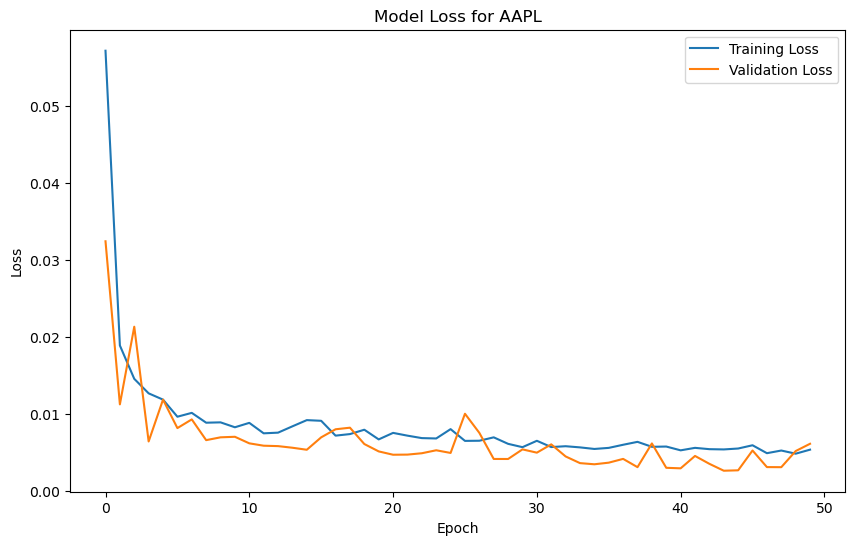

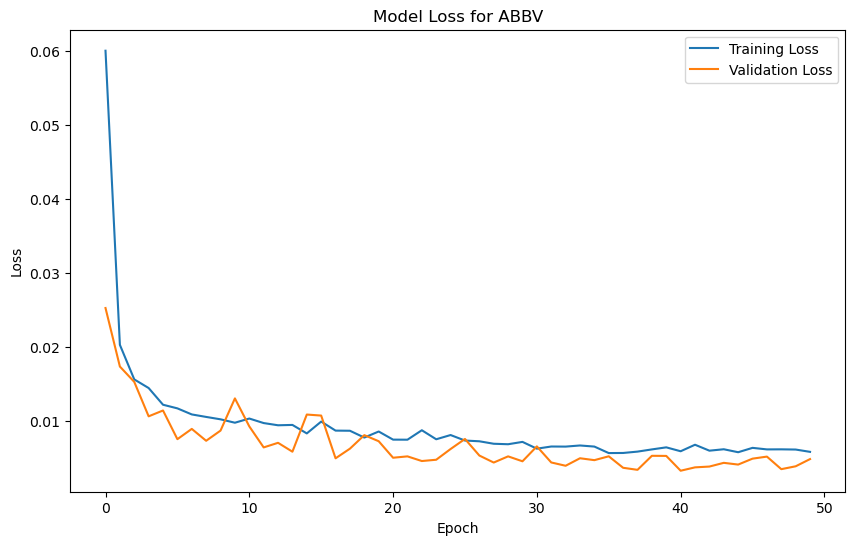

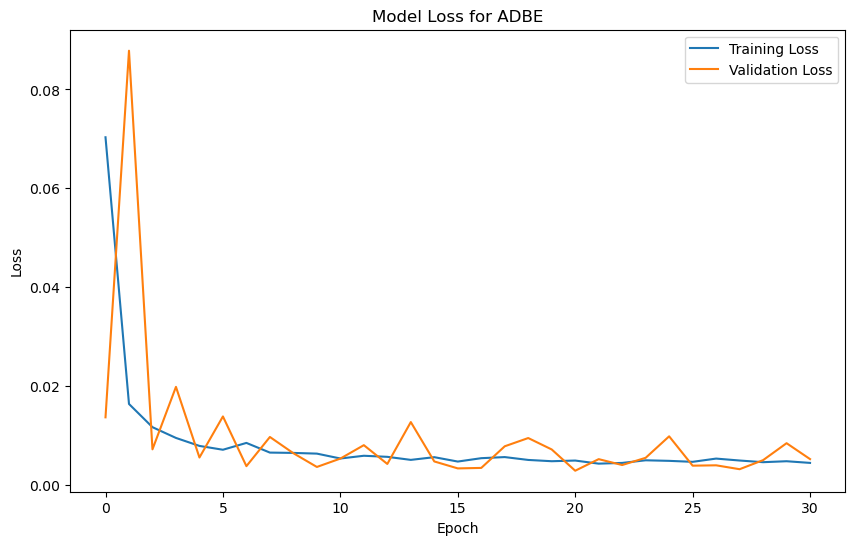

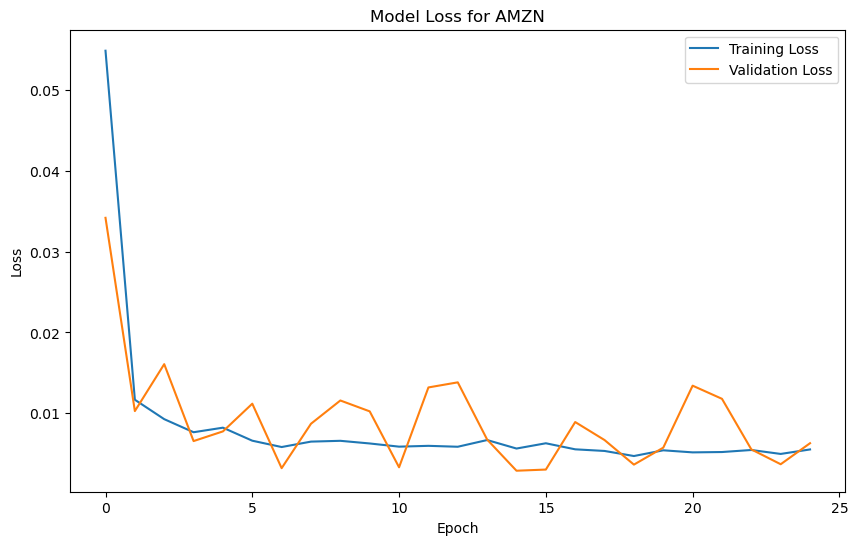

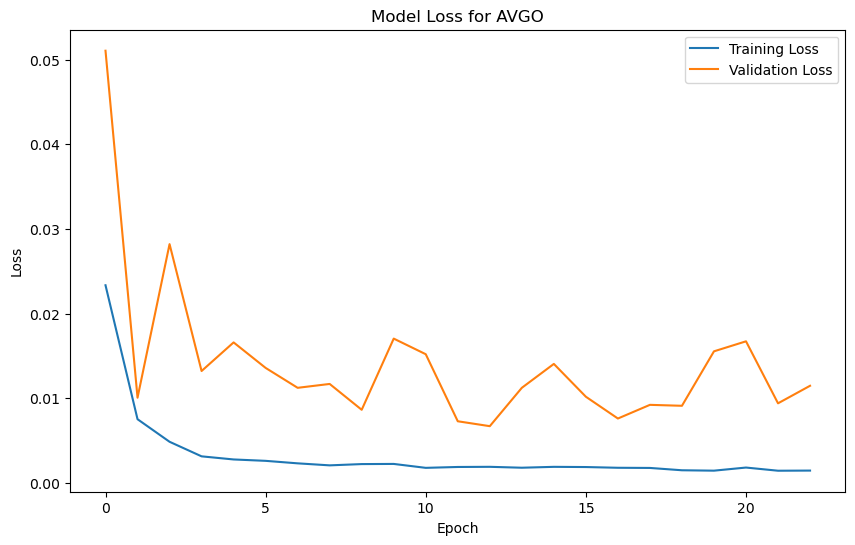

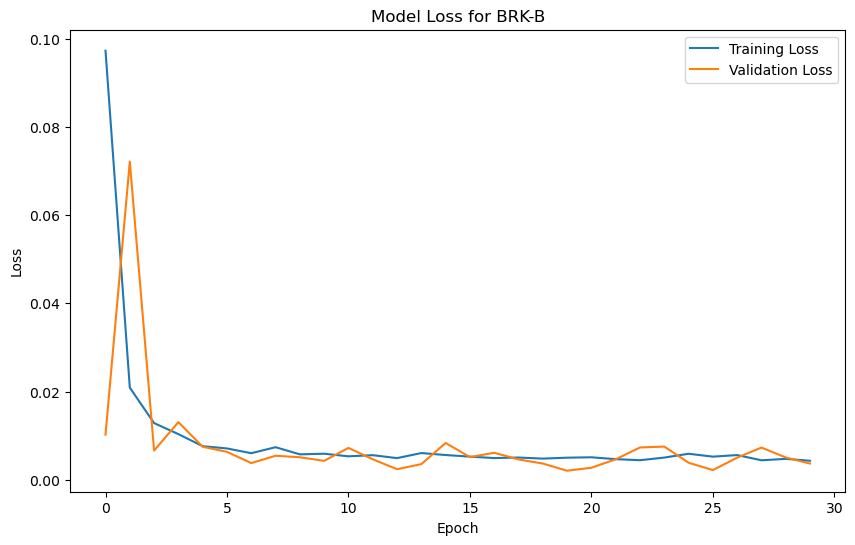

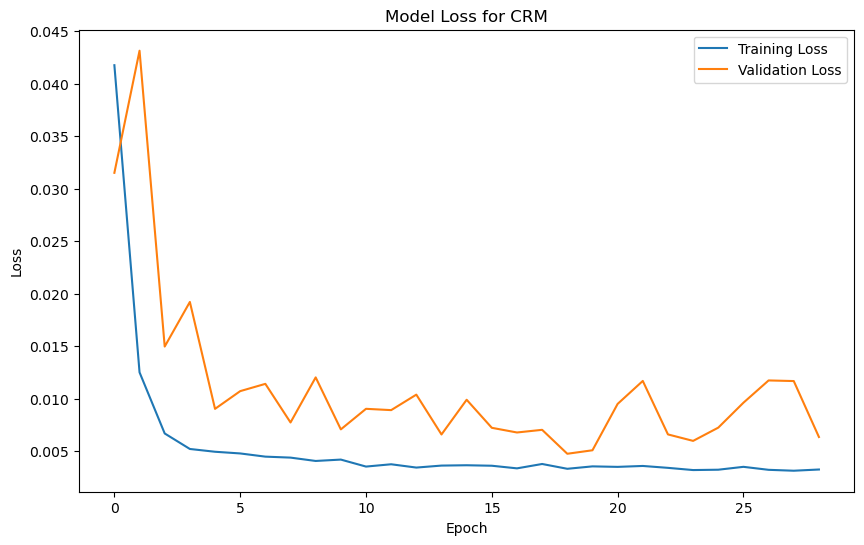

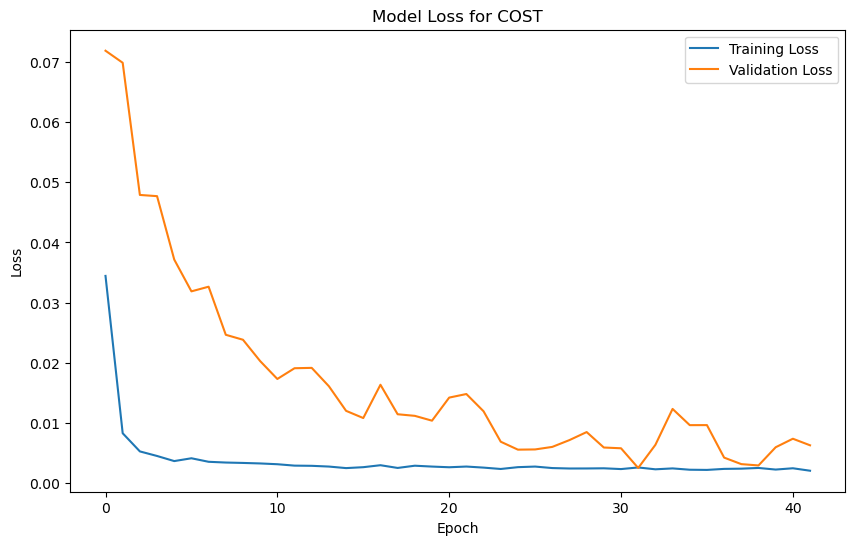

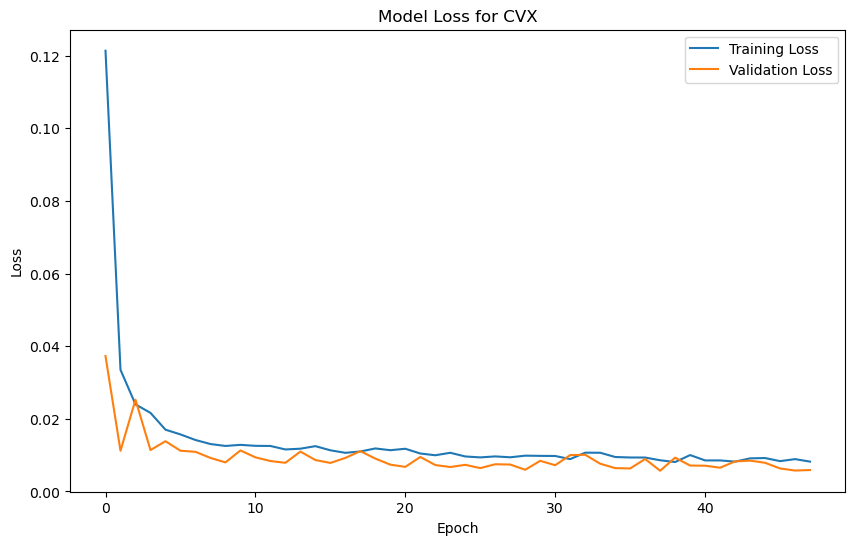

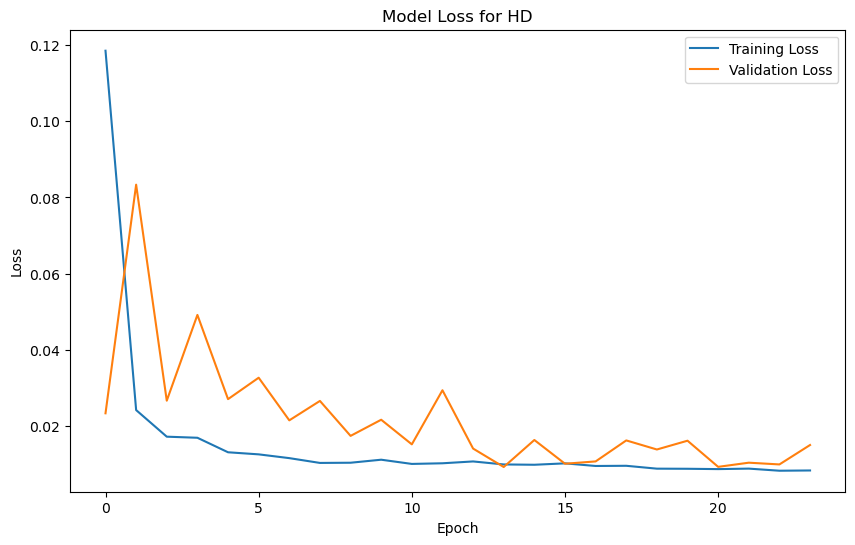

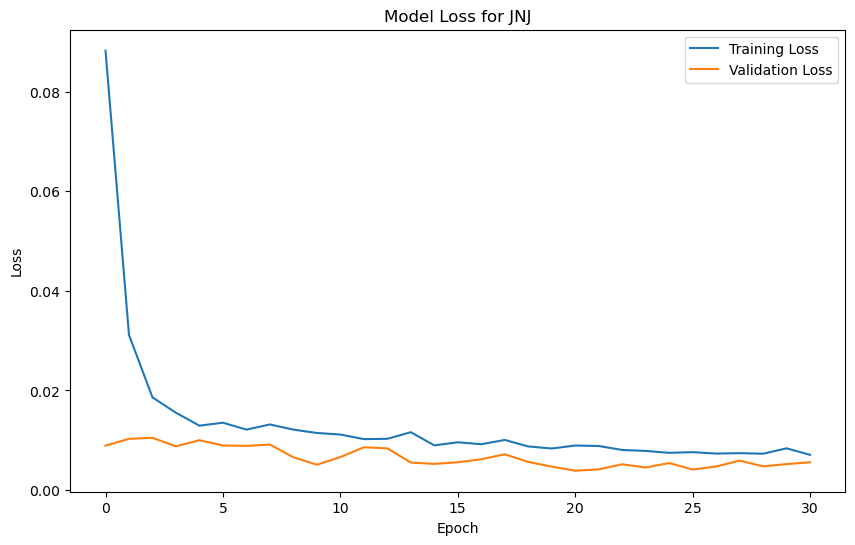

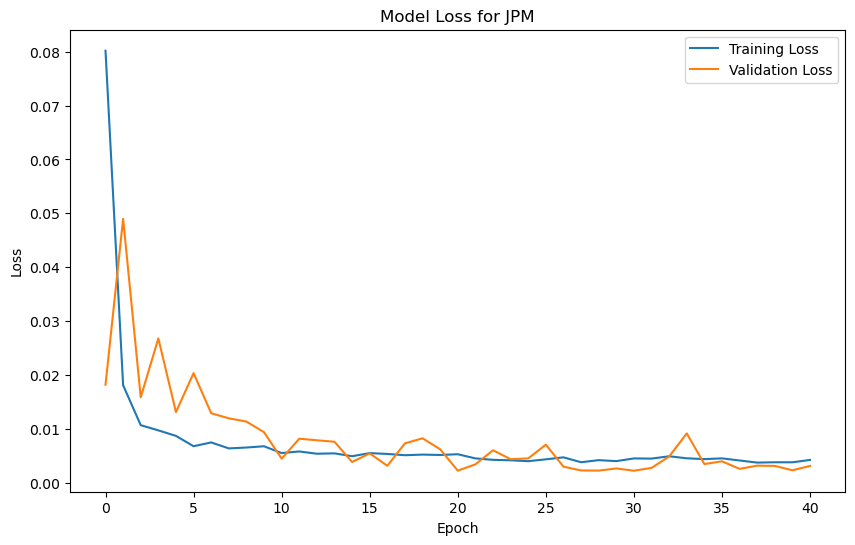

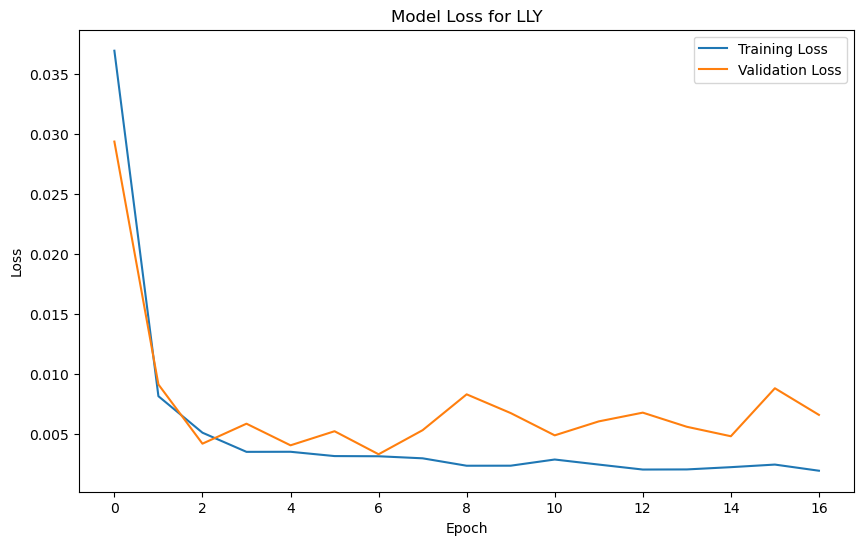

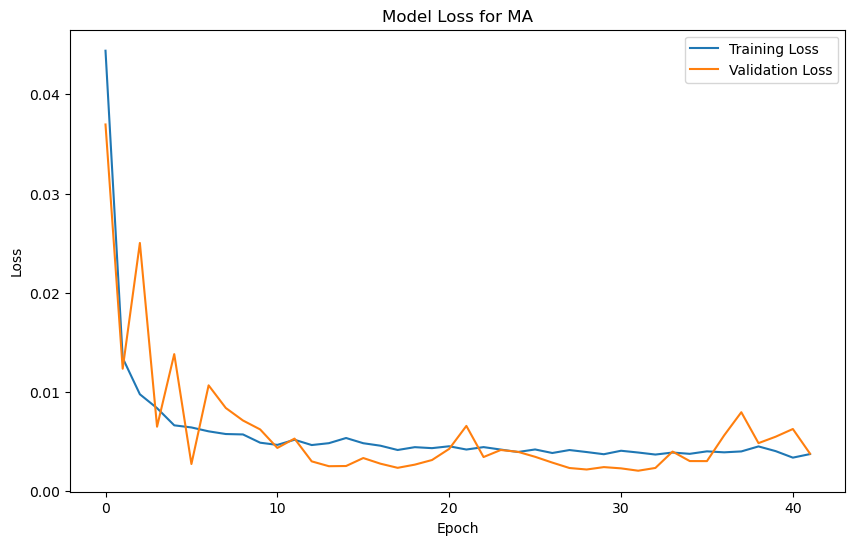

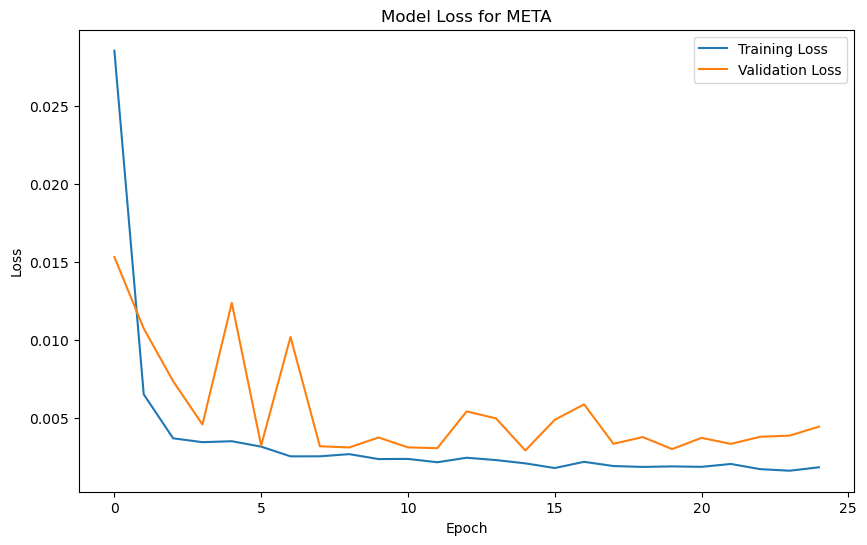

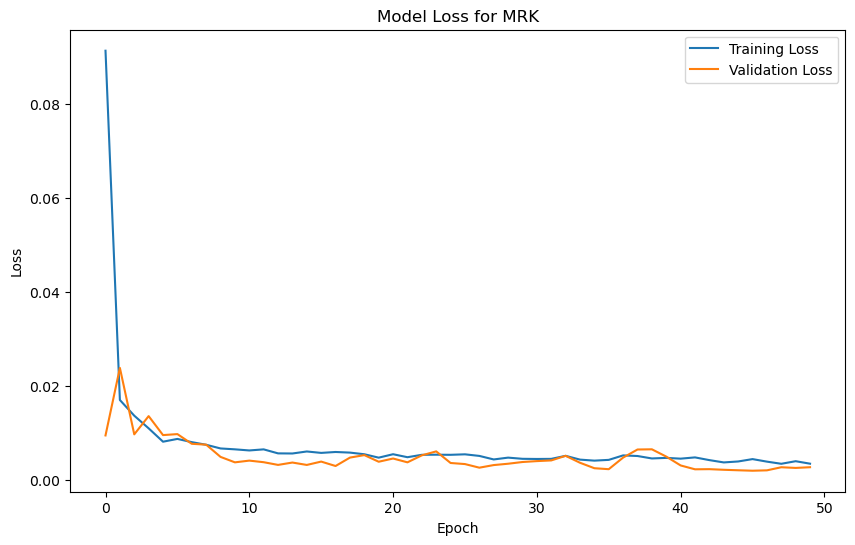

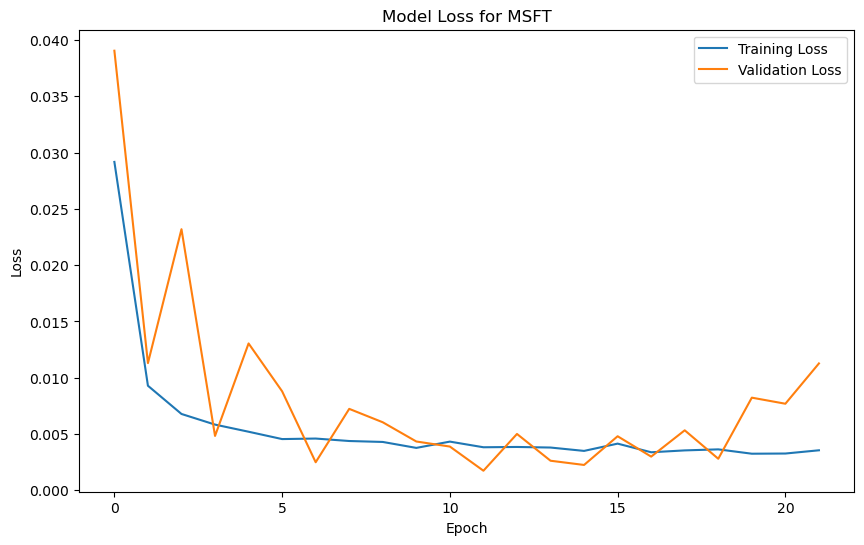

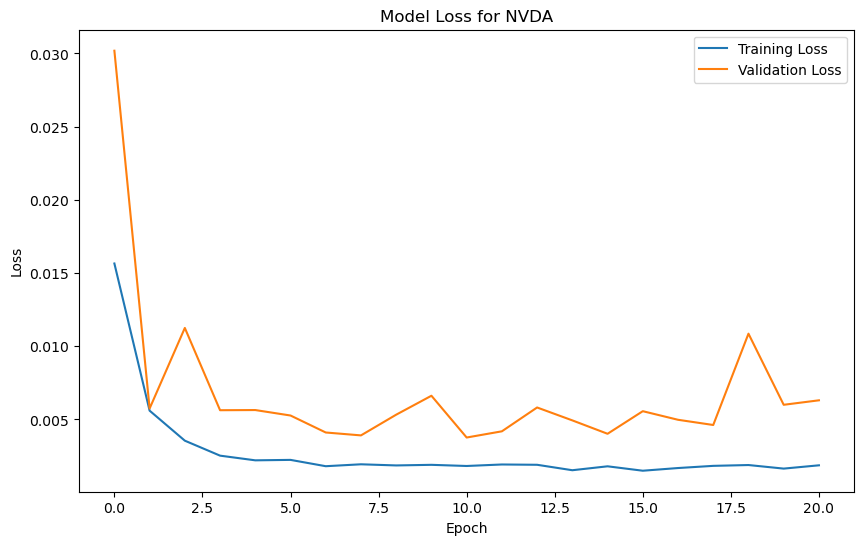

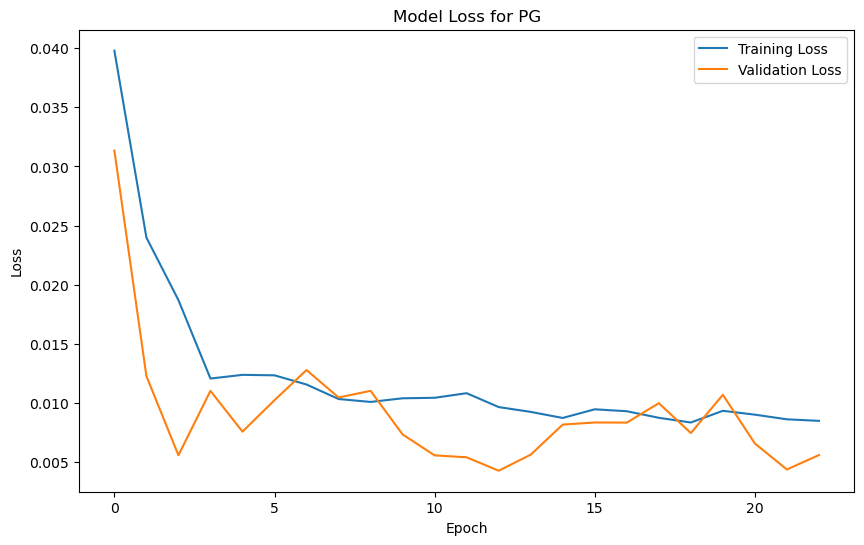

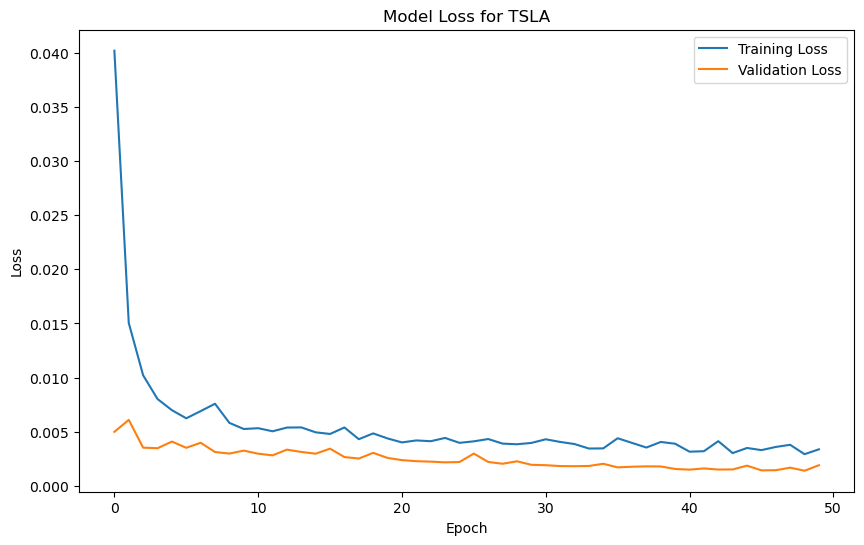

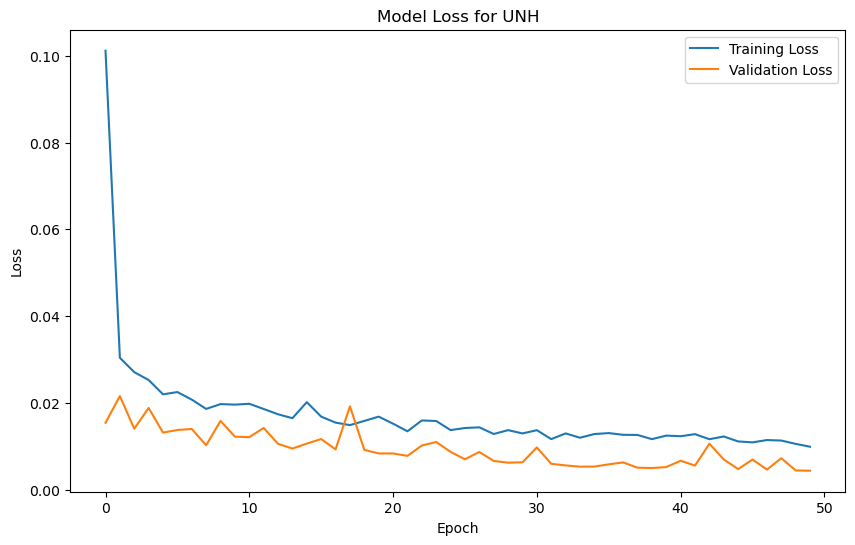

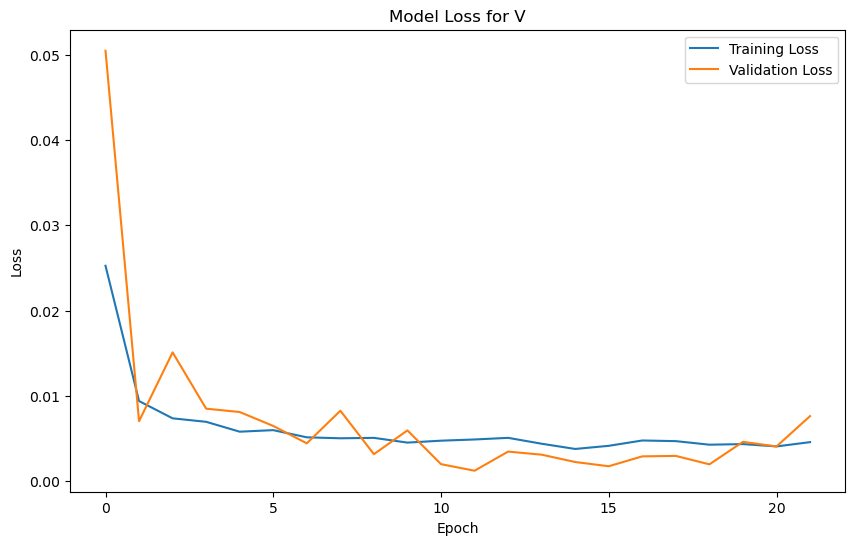

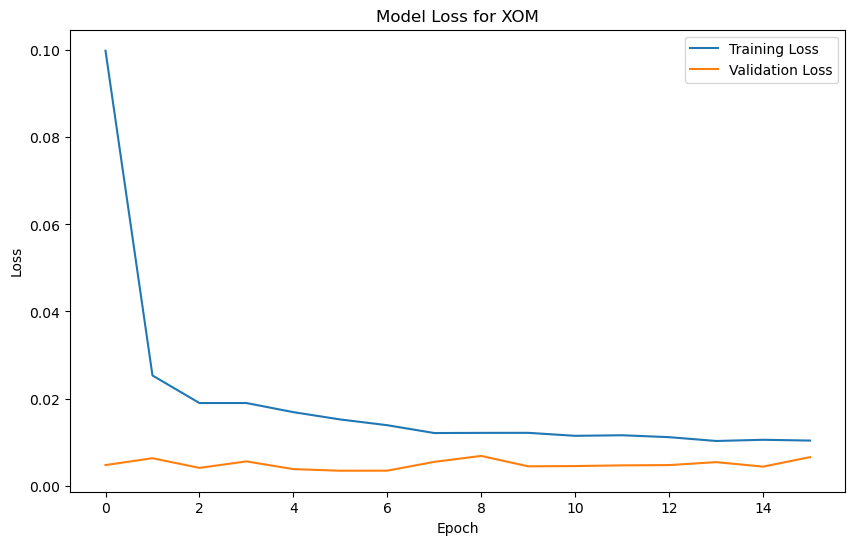

In [21]:
# Plot Model Loss
def plot_model_loss(history, stock):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss for {stock}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

for stock, history in histories.items():
    plot_model_loss(history, stock)

In [23]:
# Evaluate LSTM Model
def evaluate_model(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], 6)))))[:, 0]  # Reverse scaling for 'close' price only
    
    y_test = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 6)))))[:, 0]  # Reverse scaling for 'close' price only
    
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    
    # Calculate daily metrics
    daily_mae = np.abs(y_test - predictions)
    daily_rmse = np.sqrt((y_test - predictions)**2)
    daily_mape = (np.abs((y_test - predictions) / y_test)) * 100
    
    return mae, rmse, r2, mape, daily_mae, daily_rmse, daily_mape

evaluation_results_lstm = {}
daily_metrics_results_lstm = {}

for stock, (X, y) in prepared_data_lstm.items():
    train_size = int(len(X) * 0.8)
    X_test, y_test = X[train_size:], y[train_size:]
    scaler = scalers[stock]
    
    mae, rmse, r2, mape, daily_mae, daily_rmse, daily_mape = evaluate_model(models_lstm[stock], X_test, y_test, scaler)
    
    # Ensure consistent lengths
    date_values = stock_data[stock]['date'].values[-len(daily_mae):]
    
    # Create a DataFrame for daily metrics
    daily_metrics_df = pd.DataFrame({
        'ds': date_values,
        'daily_mae': daily_mae,
        'daily_rmse': daily_rmse,
        'daily_mape': daily_mape
    })
    
    evaluation_results_lstm[stock] = {'MAE': mae, 'RMSE': rmse, 'R²': r2, 'MAPE': mape}
    daily_metrics_results_lstm[stock] = daily_metrics_df

# Convert evaluation results to DataFrame
evaluation_df_lstm = pd.DataFrame(evaluation_results_lstm).T
display(evaluation_df_lstm)

# Concatenate all daily metrics into a single DataFrame
all_daily_metrics_df_lstm = pd.concat(daily_metrics_results_lstm.values(), keys=daily_metrics_results_lstm.keys())
all_daily_metrics_df_lstm = all_daily_metrics_df_lstm.reset_index(level=0).rename(columns={'level_0': 'Stock'})
display(all_daily_metrics_df_lstm)

# Save the consolidated daily metrics to a CSV file
all_daily_metrics_df_lstm.to_csv("consolidated_lstm_daily_metrics.csv", index=False)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


MAE       RMSE        R²      MAPE
AAPL    3.085133   3.785262  0.756448  1.672410
ABBV    1.927322   2.443070  0.946556  1.268916
ADBE   15.779282  19.378174  0.602897  2.734019
AMZN    3.849207   4.854028  0.816993  2.662844
AVGO   56.566184  69.455661  0.723228  5.392254
BRK-B   5.017883   6.059474  0.830565  1.387483
CRM     9.371291  11.282308  0.860174  3.756498
COST   11.731432  15.276703  0.922243  1.853939
CVX     3.069708   3.935234  0.698633  2.050010
HD      7.805673   9.307882  0.889868  2.374775
JNJ     1.982025   2.518131  0.670955  1.284647
JPM     2.958785   3.504991  0.917048  1.889144
LLY    20.429617  27.174999  0.401060  3.311468
MA      5.861407   8.104018  0.872013  1.460089
META   14.044240  20.756364  0.721850  3.884680
MRK     1.763485   2.231649  0.925034  1.595202
MSFT    7.001432   8.330869  0.879708  1.889579
NVDA   28.872967  36.133419  0.748590  5.574729
PG      2.068195   2.606411  0.576698  1.376849
TSLA    7.592821  10.223309  0.793850  3.367730
UNH     5.505805   7.104156  0.714343  1.039647
V       2.786651   3.528549  0.929565  1.124103
XOM     2.056203   2.527456  0.560536  2.002054

Stock         ds  daily_mae  daily_rmse  daily_mape
0   AAPL 2023-10-09   4.453112    4.453112    2.487911
1   AAPL 2023-10-10   3.221639    3.221639    1.805953
2   AAPL 2023-10-11   3.682574    3.682574    2.048150
3   AAPL 2023-10-12   3.383735    3.383735    1.872467
4   AAPL 2023-10-13   0.399848    0.399848    0.223566
..   ...        ...        ...         ...         ...
80   XOM 2024-02-02   1.446068    1.446068    1.418131
81   XOM 2024-02-05   0.518912    0.518912    0.510992
82   XOM 2024-02-06   0.777136    0.777136    0.760035
83   XOM 2024-02-07   0.354685    0.354685    0.346982
84   XOM 2024-02-08   1.760590    1.760590    1.693363

[1955 rows x 5 columns]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  174.536894  167.152635  181.921152  178.990005
418 2023-10-10  175.168360  167.784102  182.552619  178.389999
419 2023-10-11  176.117429  168.733170  183.501687  179.800003
420 2023-10-12  177.326271  169.942013  184.710530  180.710007
421 2023-10-13  178.450158  171.065900  185.834416  178.850006
..         ...         ...         ...         ...         ...
497 2024-02-02  188.755916  181.371658  196.140175  185.850006
498 2024-02-05  187.230012  179.845753  194.614270  187.679993
499 2024-02-06  186.691247  179.306989  194.075506  189.300003
500 2024-02-07  186.985472  179.601214  194.369731  189.410004
501 2024-02-08  187.212333  179.828074  194.596591  188.320007

[85 rows x 5 columns]

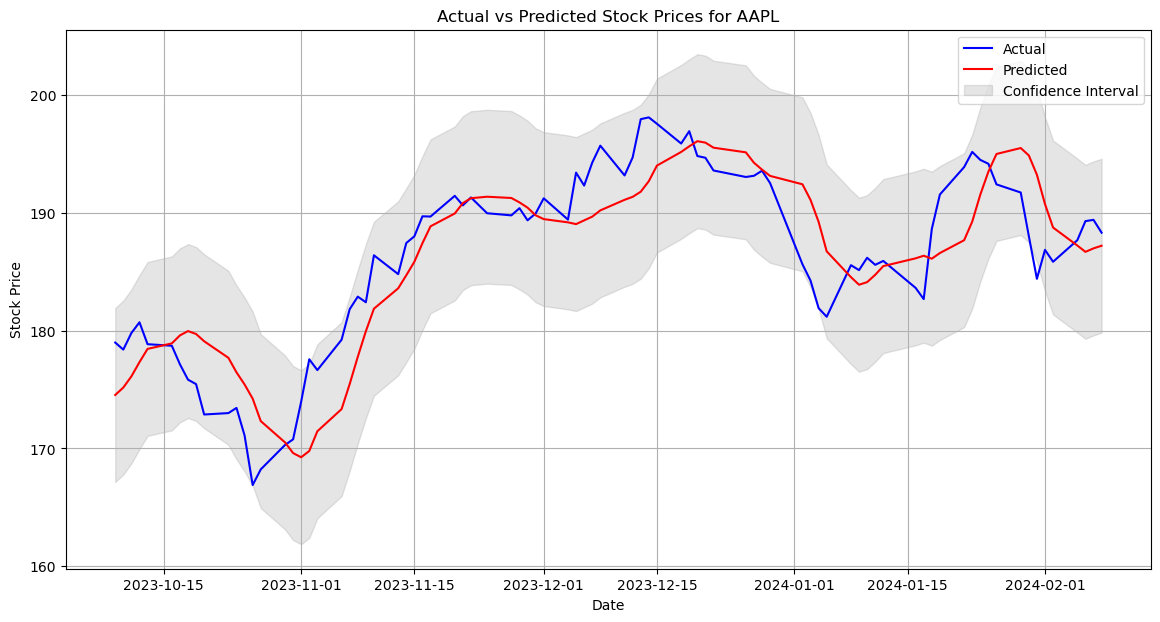

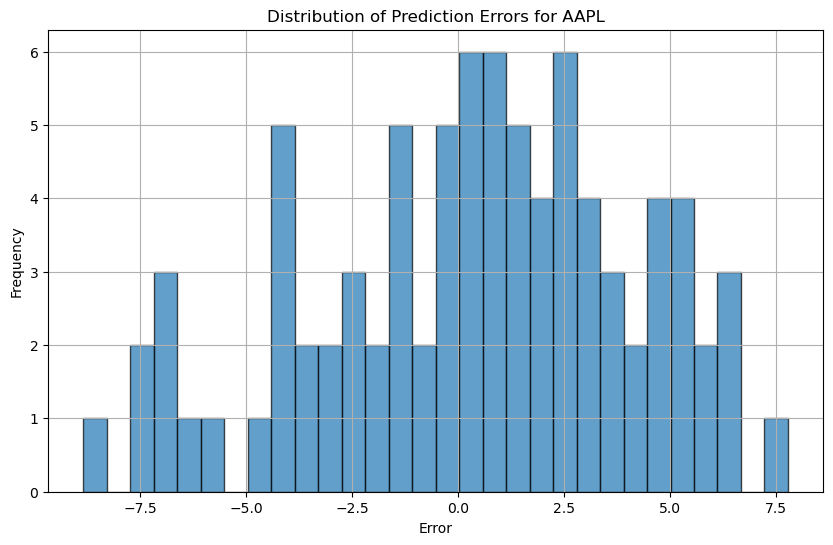

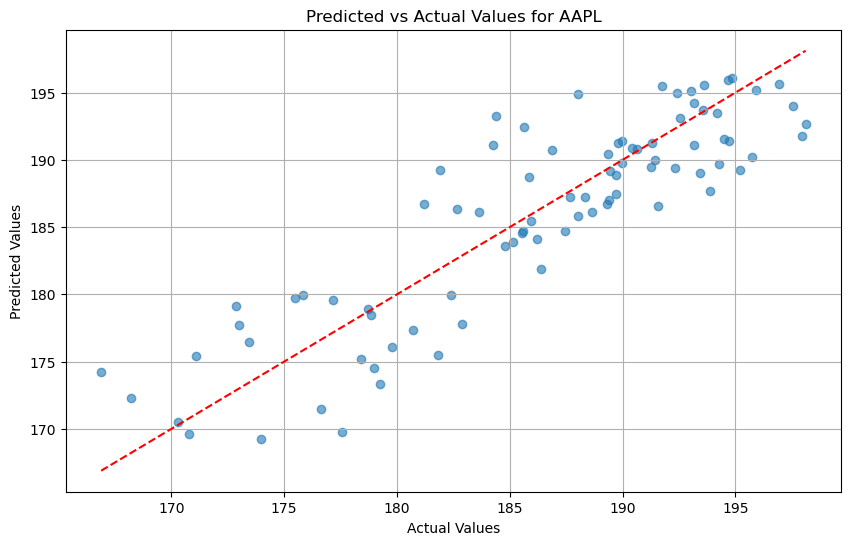

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  147.102094  142.322884  151.881305  149.110001
418 2023-10-10  147.275421  142.496210  152.054632  148.889999
419 2023-10-11  147.716899  142.937688  152.496110  149.339996
420 2023-10-12  148.369799  143.590588  153.149010  148.300003
421 2023-10-13  148.842124  144.062913  153.621334  147.960007
..         ...         ...         ...         ...         ...
497 2024-02-02  164.507667  159.728456  169.286878  168.669998
498 2024-02-05  165.872278  161.093067  170.651488  171.259995
499 2024-02-06  167.896525  163.117315  172.675736  173.289993
500 2024-02-07  170.039750  165.260539  174.818960  175.009995
501 2024-02-08  171.992941  167.213730  176.772152  174.789993

[85 rows x 5 columns]

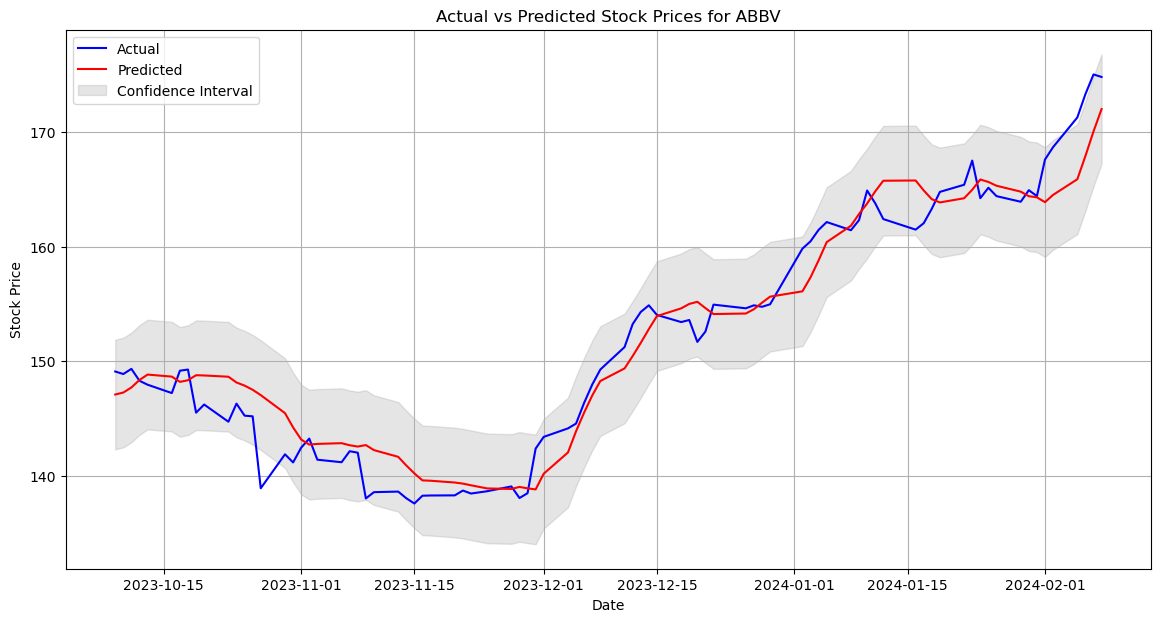

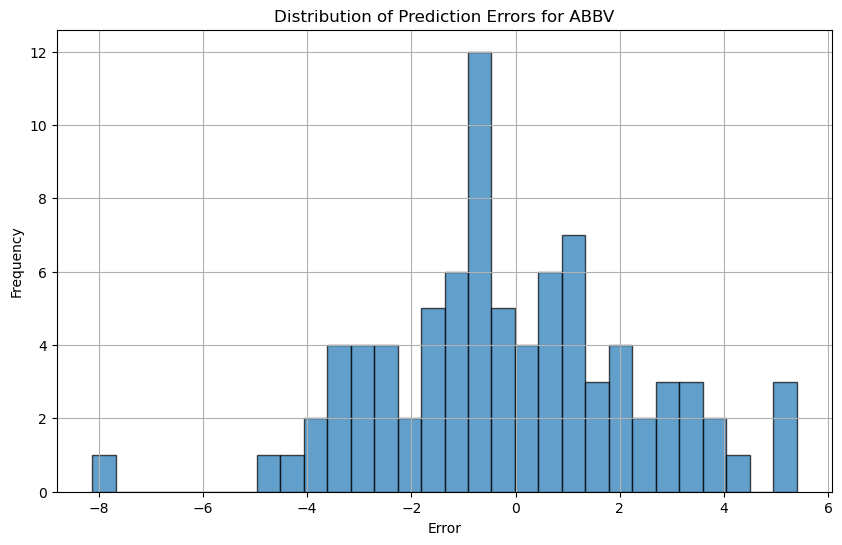

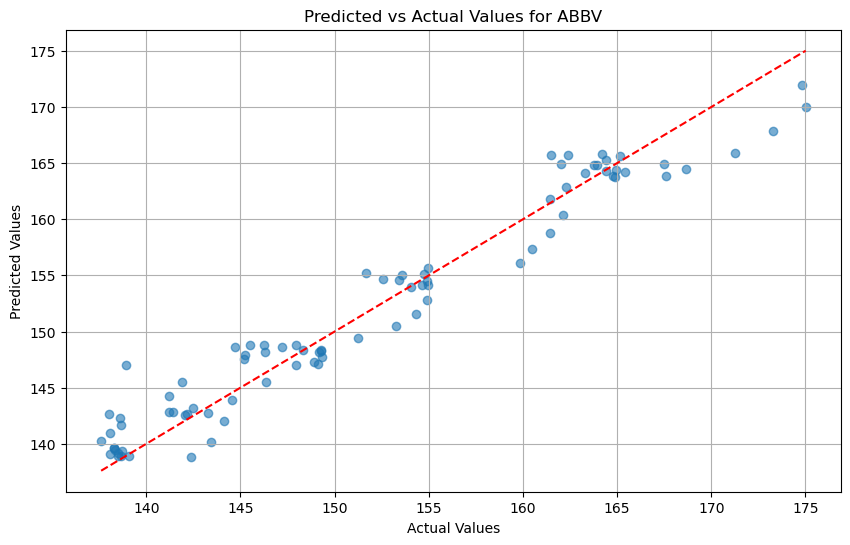

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  511.958725  475.162113  548.755336  529.289978
418 2023-10-10  514.724410  477.927798  551.521022  532.719971
419 2023-10-11  518.185396  481.388784  554.982007  549.909973
420 2023-10-12  524.490720  487.694108  561.287332  559.630005
421 2023-10-13  532.215535  495.418923  569.012146  548.760010
..         ...         ...         ...         ...         ...
497 2024-02-02  620.325567  583.528955  657.122178  634.760010
498 2024-02-05  621.755151  584.958539  658.551763  630.500000
499 2024-02-06  623.055890  586.259278  659.852502  607.140015
500 2024-02-07  622.745605  585.948994  659.542217  615.849976
501 2024-02-08  622.019079  585.222468  658.815691  615.859985

[85 rows x 5 columns]

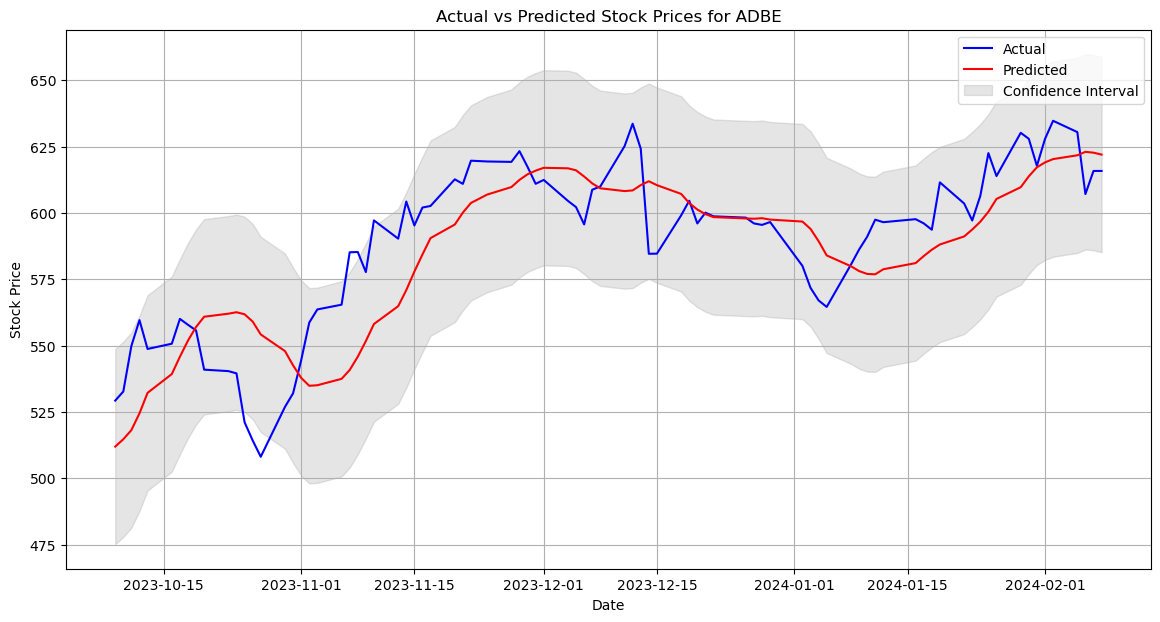

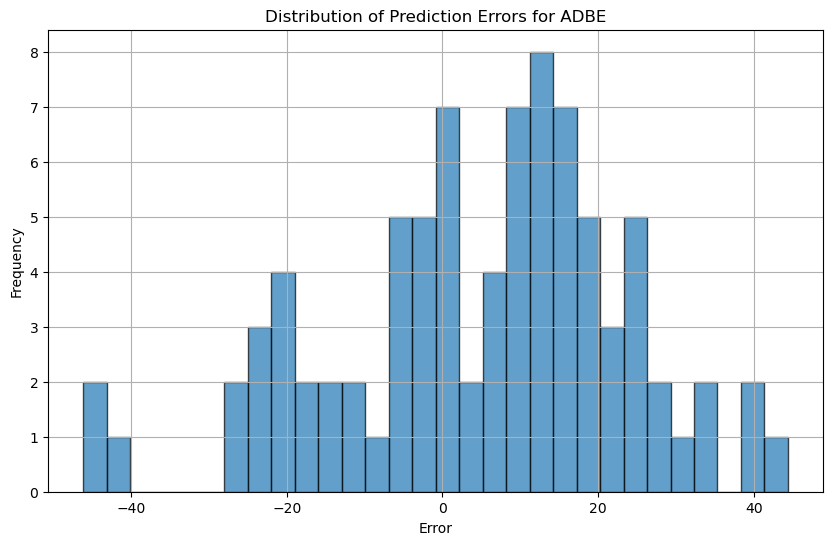

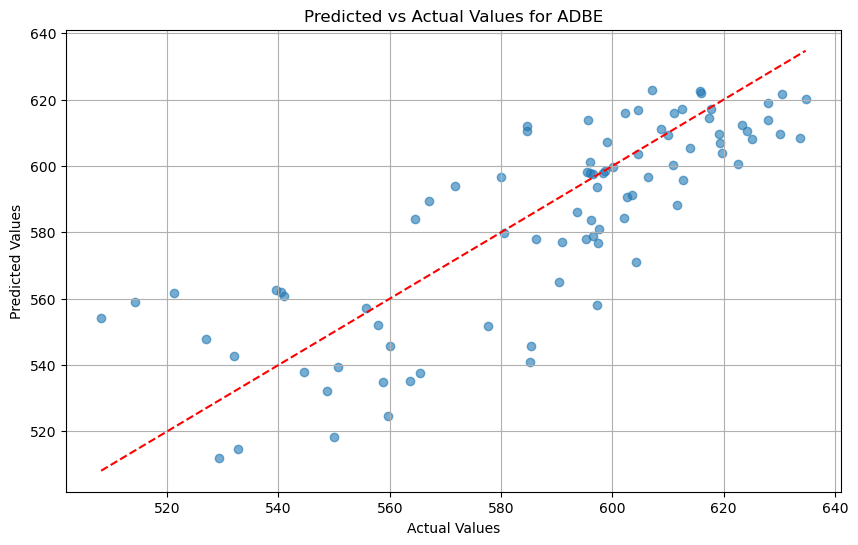

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  126.211880  116.864782  135.558978  128.259995
418 2023-10-10  125.760514  116.413416  135.107612  129.479996
419 2023-10-11  125.711545  116.364447  135.058643  131.830002
420 2023-10-12  126.338072  116.990974  135.685170  132.330002
421 2023-10-13  127.336813  117.989715  136.683911  129.789993
..         ...         ...         ...         ...         ...
497 2024-02-02  158.863722  149.516623  168.210820  171.809998
498 2024-02-05  159.521728  150.174630  168.868827  170.309998
499 2024-02-06  160.555047  151.207949  169.902145  169.149994
500 2024-02-07  161.736960  152.389862  171.084058  170.529999
501 2024-02-08  162.926591  153.579493  172.273689  169.839996

[85 rows x 5 columns]

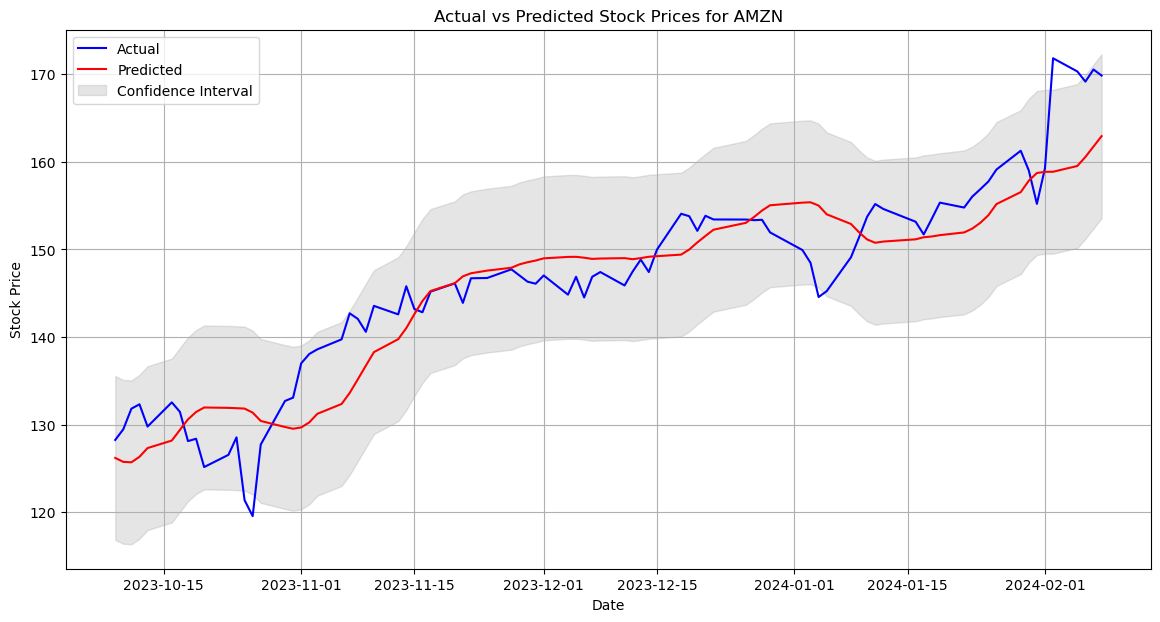

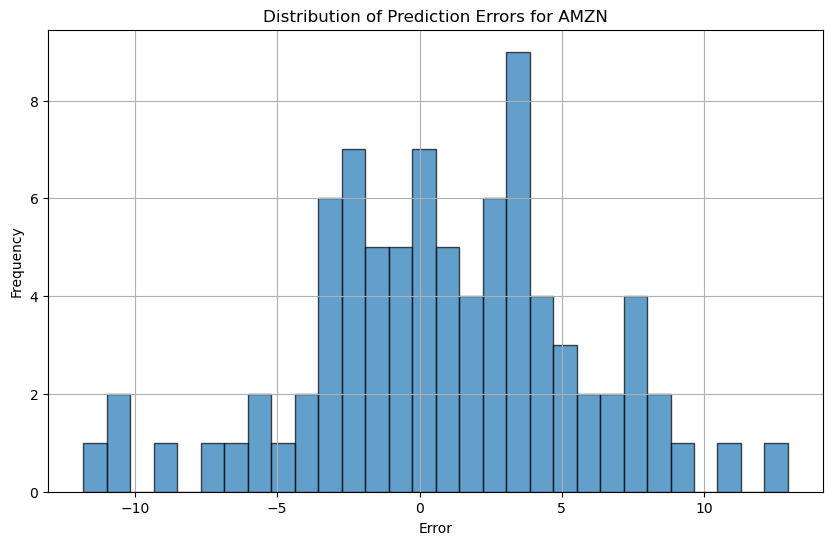

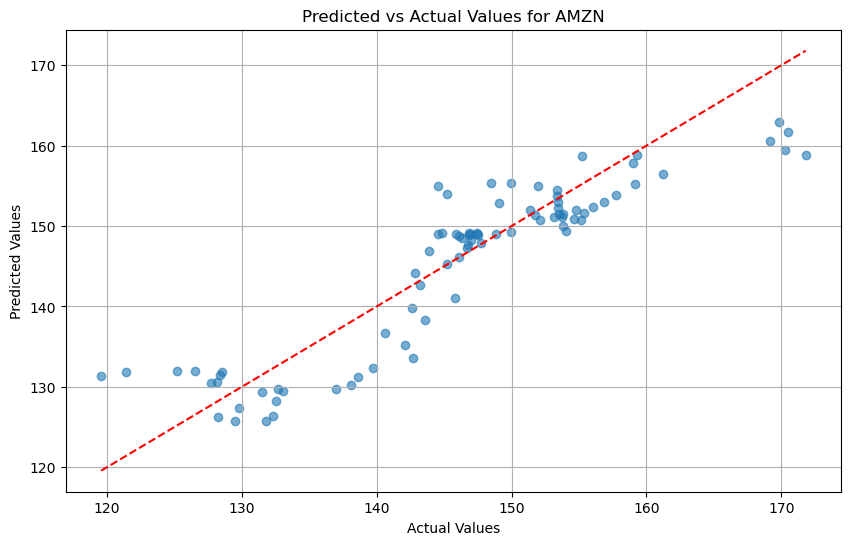

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


ds         yhat   yhat_lower   yhat_upper            y
417 2023-10-09   842.486004   713.721094   971.250914   855.880005
418 2023-10-10   844.109330   715.344420   972.874240   858.409973
419 2023-10-11   847.847282   719.082372   976.612192   874.559998
420 2023-10-12   854.615566   725.850656   983.380476   905.599976
421 2023-10-13   863.620998   734.856088   992.385908   883.179993
..         ...          ...          ...          ...          ...
497 2024-02-02  1172.237719  1043.472809  1301.002629  1224.339966
498 2024-02-05  1175.357150  1046.592240  1304.122060  1243.099976
499 2024-02-06  1178.151002  1049.386092  1306.915912  1222.650024
500 2024-02-07  1180.411063  1051.646153  1309.175973  1257.060059
501 2024-02-08  1182.610848  1053.845938  1311.375758  1274.760010

[85 rows x 5 columns]

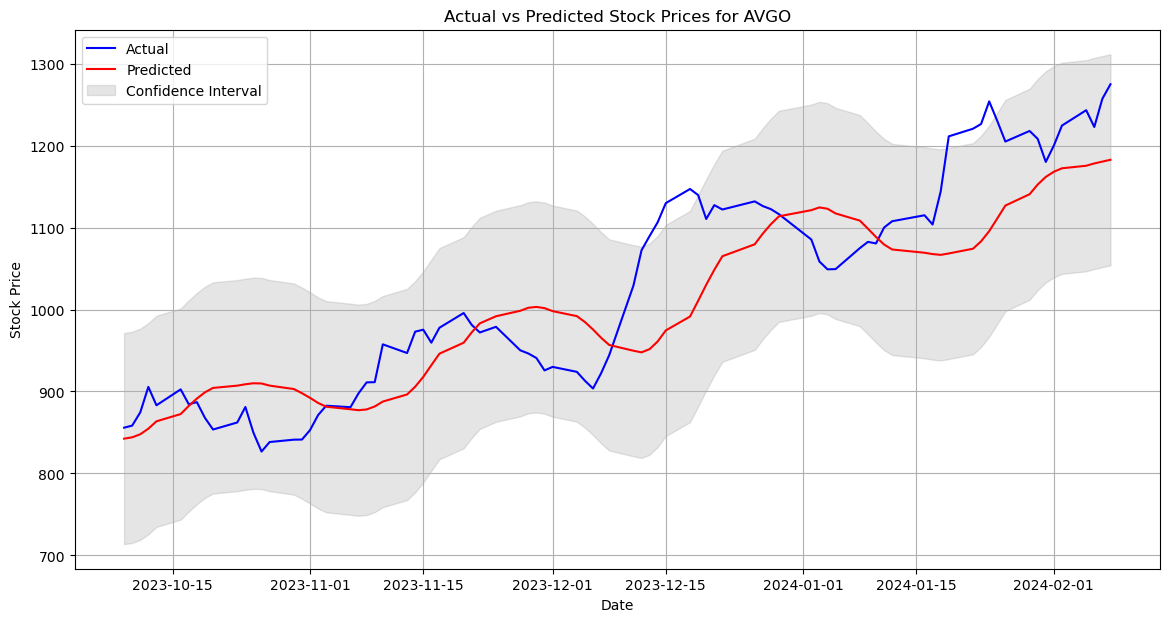

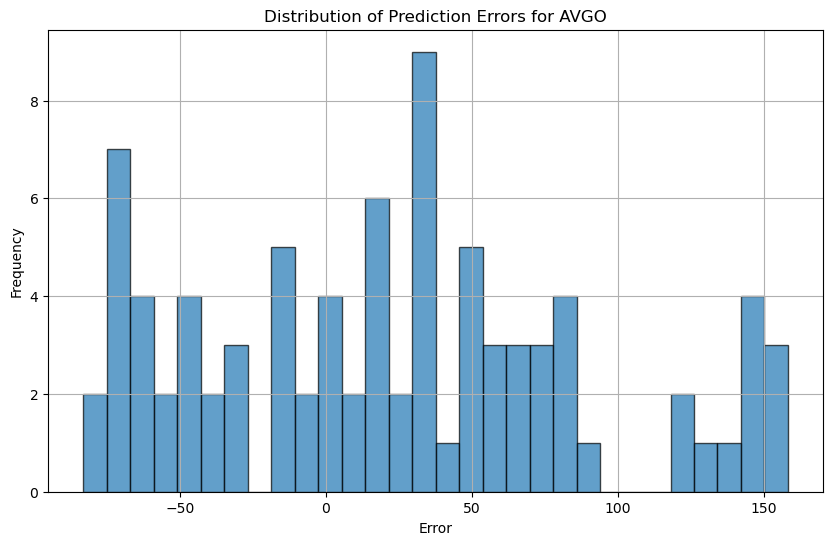

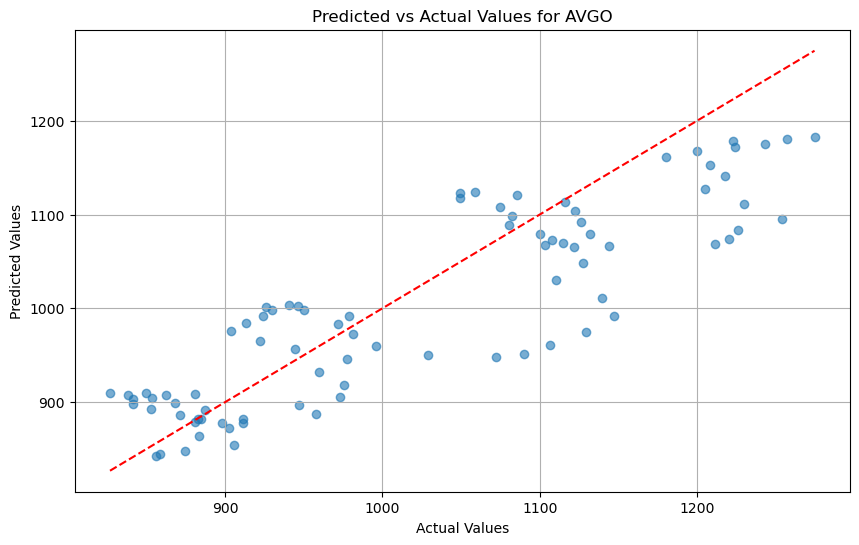

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  349.800006  338.122899  361.477113  345.450012
418 2023-10-10  347.335784  335.658677  359.012891  348.559998
419 2023-10-11  345.606002  333.928895  357.283109  348.429993
420 2023-10-12  344.478299  332.801192  356.155406  345.660004
421 2023-10-13  343.712200  332.035093  355.389307  345.089996
..         ...         ...         ...         ...         ...
497 2024-02-02  381.532220  369.855113  393.209327  390.750000
498 2024-02-05  383.530769  371.853662  395.207876  390.760010
499 2024-02-06  385.653918  373.976811  397.331025  393.739990
500 2024-02-07  387.903363  376.226256  399.580470  397.660004
501 2024-02-08  390.165779  378.488672  401.842886  397.489990

[85 rows x 5 columns]

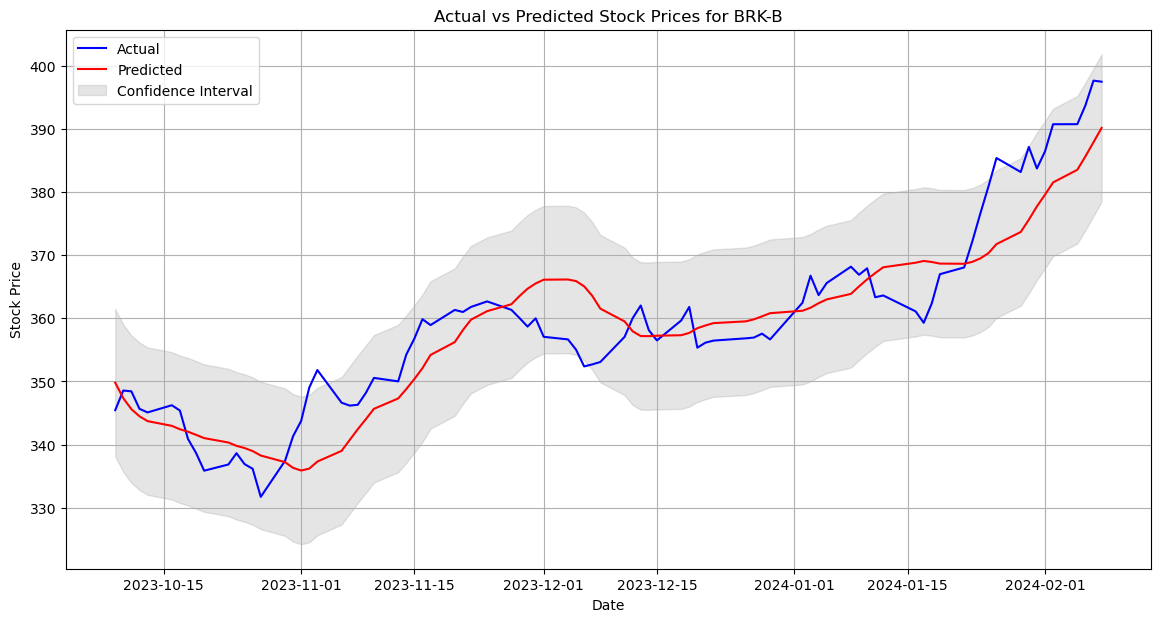

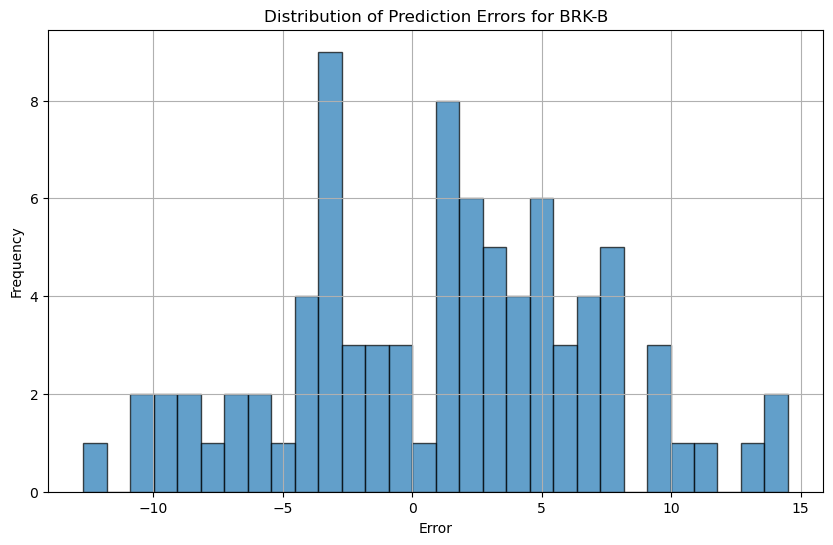

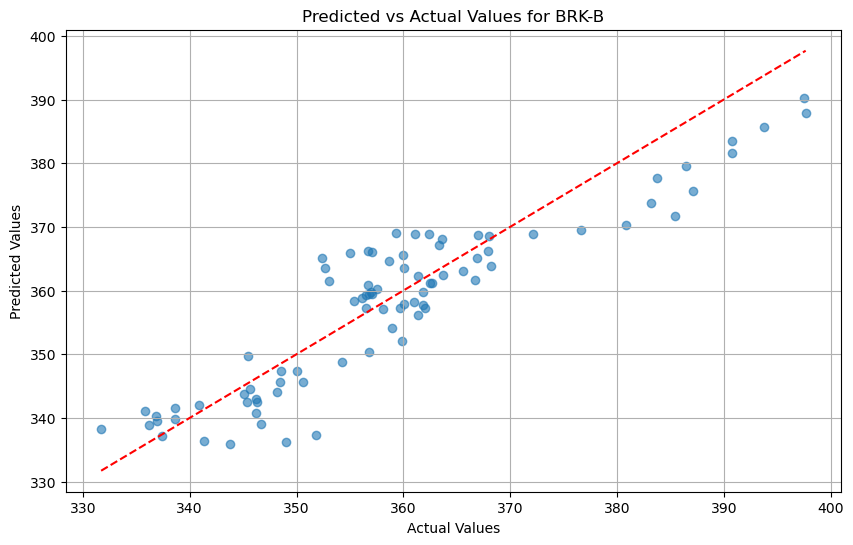

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  200.823665  181.854373  219.792957  207.220001
418 2023-10-10  201.826425  182.857133  220.795718  206.880005
419 2023-10-11  203.157907  184.188615  222.127199  206.850006
420 2023-10-12  204.862198  185.892906  223.831490  205.679993
421 2023-10-13  206.624324  187.655032  225.593616  204.589996
..         ...         ...         ...         ...         ...
497 2024-02-02  276.762016  257.792724  295.731308  285.660004
498 2024-02-05  276.564826  257.595534  295.534118  288.109985
499 2024-02-06  276.783499  257.814207  295.752791  285.829987
500 2024-02-07  276.968796  257.999504  295.938089  288.839996
501 2024-02-08  277.307528  258.338236  296.276820  291.950012

[85 rows x 5 columns]

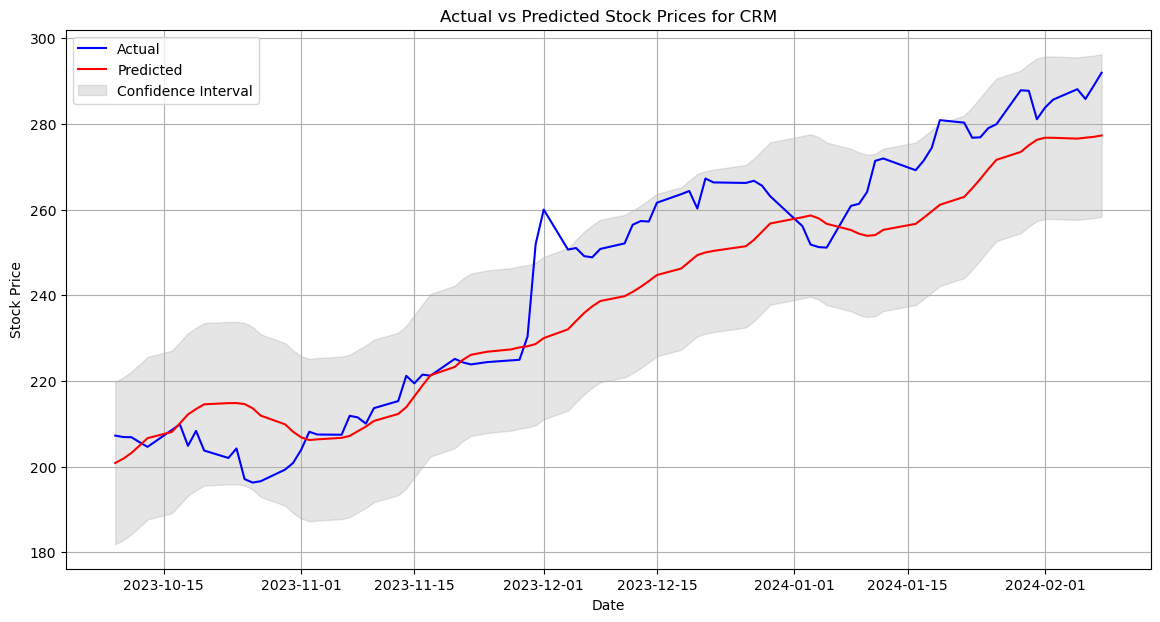

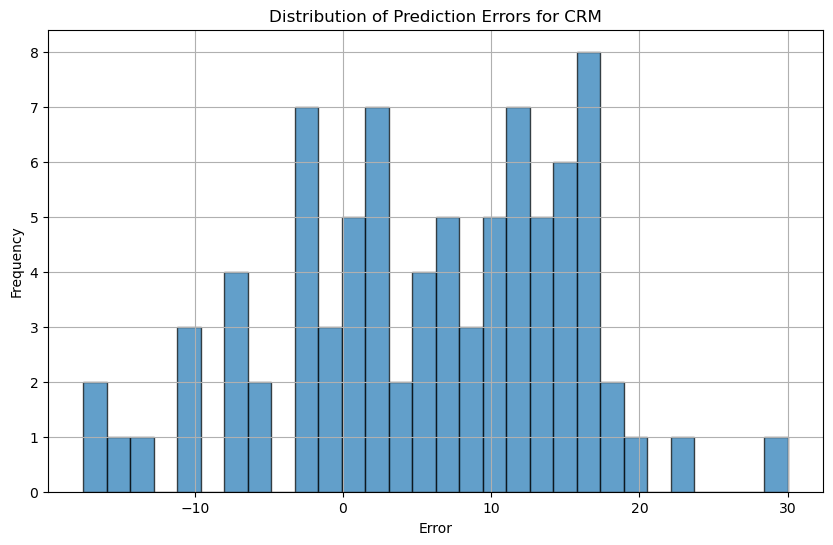

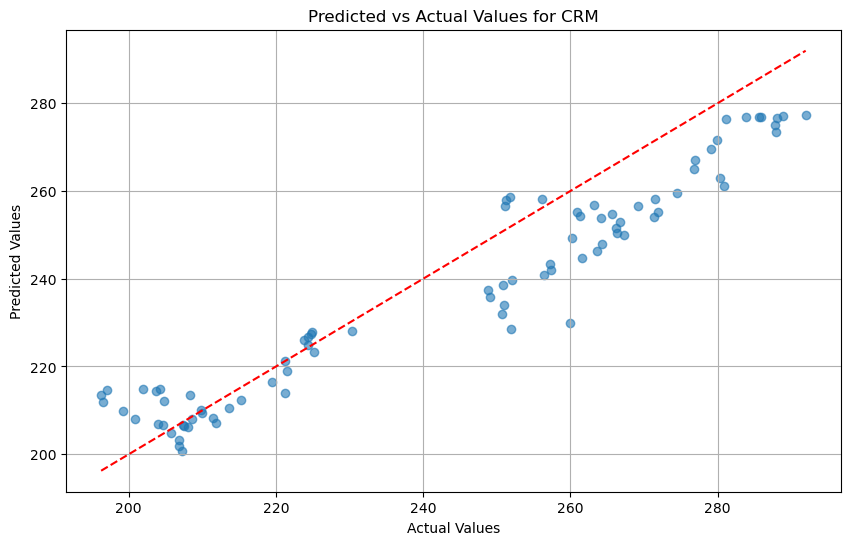

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  569.782770  542.725302  596.840238  558.969971
418 2023-10-10  568.755307  541.697839  595.812775  562.090027
419 2023-10-11  567.861376  540.803908  594.918844  565.520020
420 2023-10-12  568.250642  541.193174  595.308110  563.780029
421 2023-10-13  568.829098  541.771630  595.886566  566.840027
..         ...         ...         ...         ...         ...
497 2024-02-02  702.534668  675.477200  729.592136  709.479980
498 2024-02-05  703.821827  676.764359  730.879295  711.159973
499 2024-02-06  705.758629  678.701161  732.816097  710.789978
500 2024-02-07  707.773439  680.715971  734.830907  719.780029
501 2024-02-08  710.239301  683.181833  737.296769  724.159973

[85 rows x 5 columns]

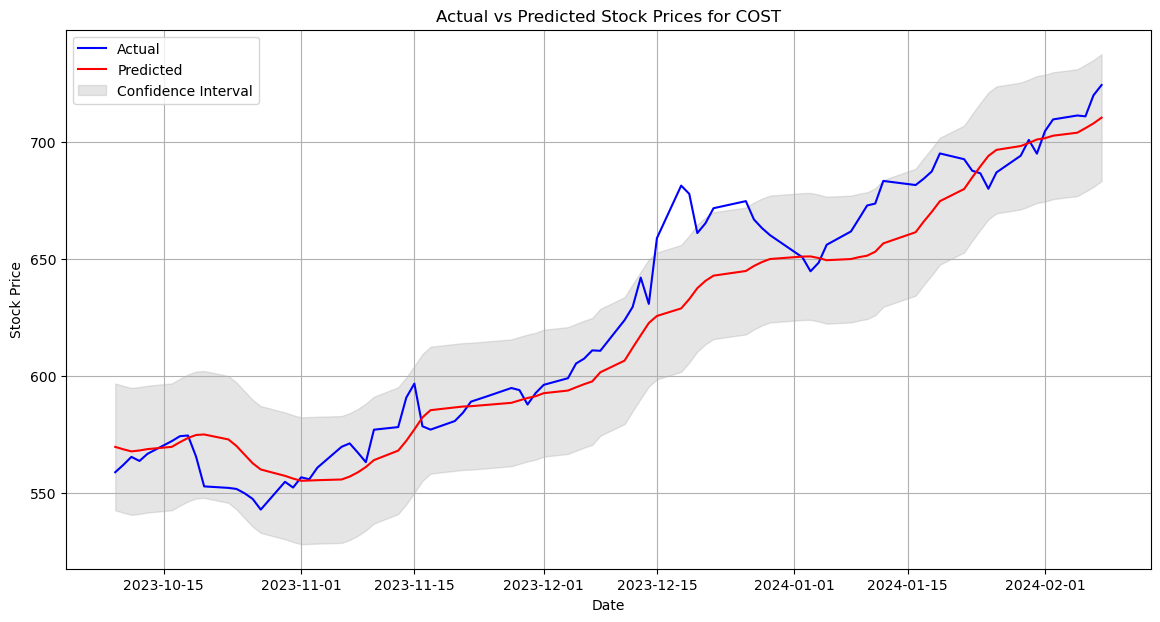

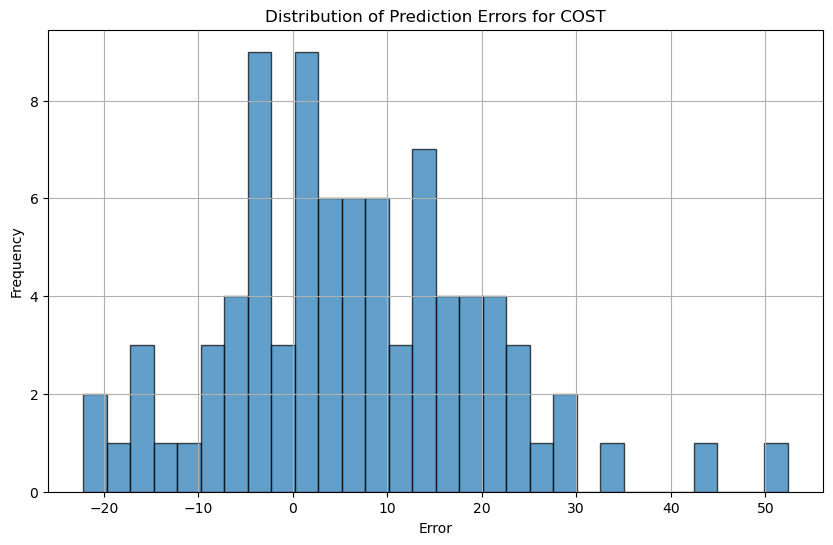

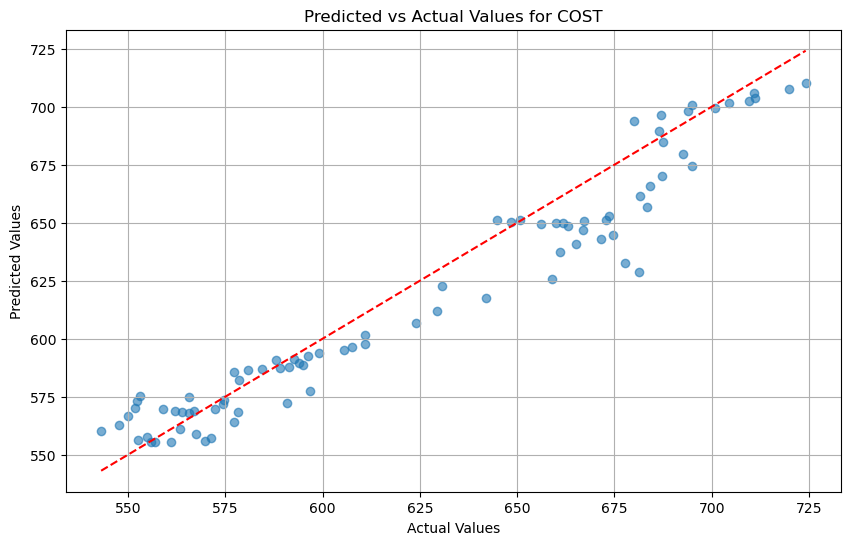

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  161.501859  154.259479  168.744239  166.720001
418 2023-10-10  161.362904  154.120524  168.605284  166.539993
419 2023-10-11  161.726031  154.483651  168.968411  161.100006
420 2023-10-12  161.548674  154.306294  168.791054  161.229996
421 2023-10-13  161.053909  153.811529  168.296289  164.059998
..         ...         ...         ...         ...         ...
497 2024-02-02  150.887264  143.644884  158.129644  152.240005
498 2024-02-05  151.620506  144.378127  158.862886  152.330002
499 2024-02-06  152.686382  145.444003  159.928762  152.350006
500 2024-02-07  153.718274  146.475894  160.960654  152.130005
501 2024-02-08  154.639690  147.397310  161.882070  154.059998

[85 rows x 5 columns]

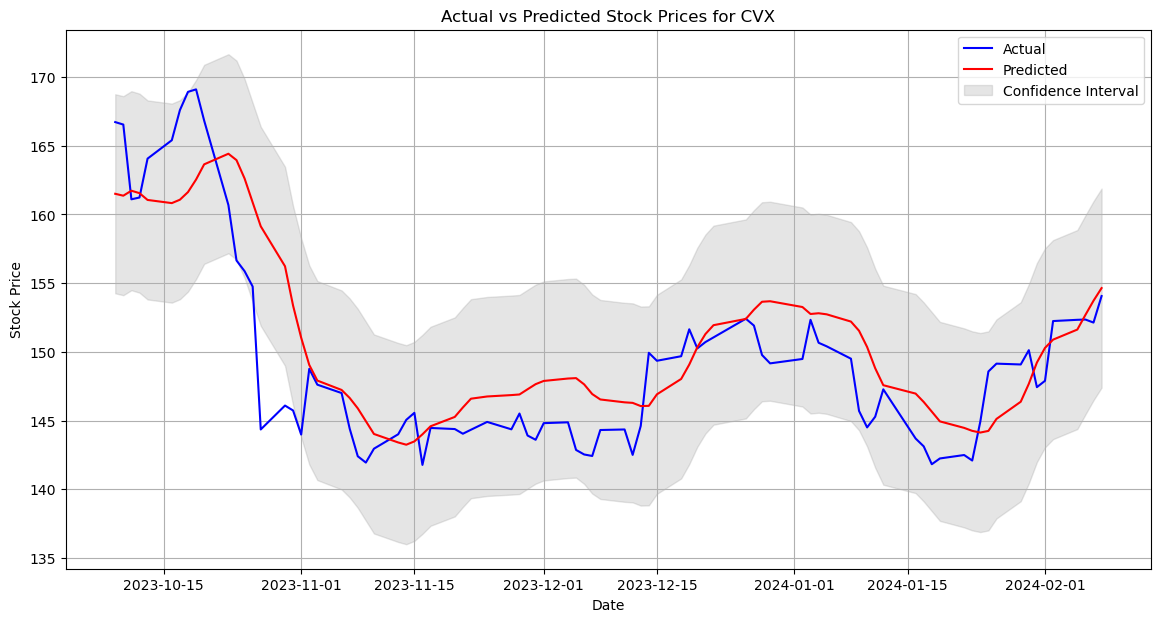

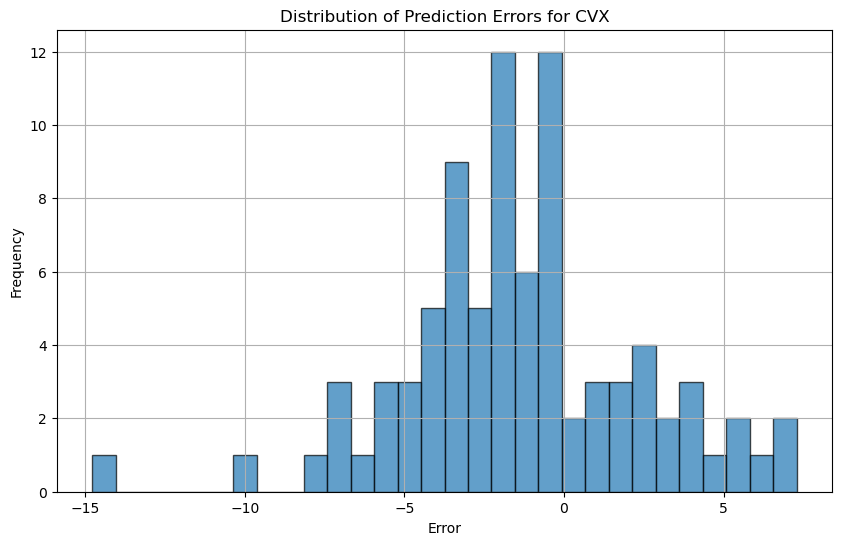

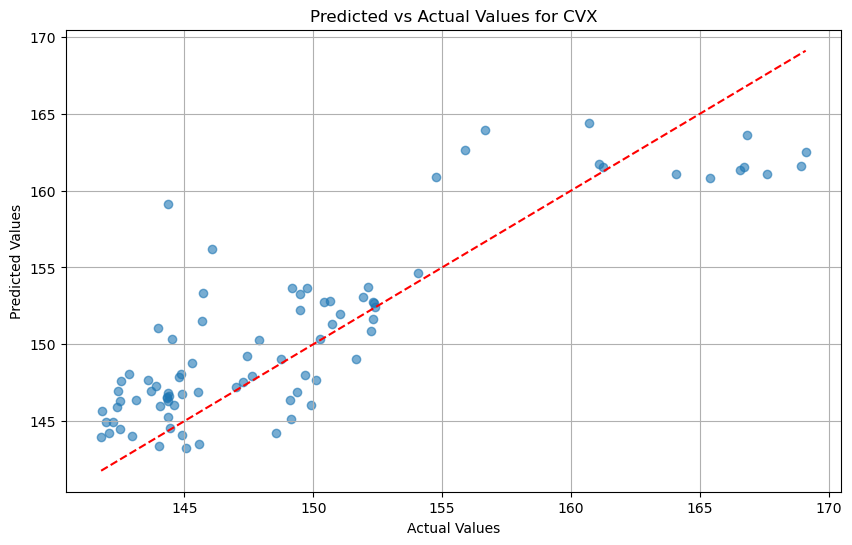

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  290.396774  275.826315  304.967232  295.359985
418 2023-10-10  288.886208  274.315750  303.456666  299.220001
419 2023-10-11  288.205877  273.635419  302.776335  298.049988
420 2023-10-12  288.213787  273.643329  302.784245  293.019989
421 2023-10-13  288.557476  273.987018  303.127934  291.920013
..         ...         ...         ...         ...         ...
497 2024-02-02  347.212427  332.641969  361.782885  357.230011
498 2024-02-05  347.181480  332.611022  361.751938  355.140015
499 2024-02-06  347.184780  332.614322  361.755238  356.250000
500 2024-02-07  347.220742  332.650283  361.791200  362.690002
501 2024-02-08  347.510977  332.940519  362.081435  363.720001

[85 rows x 5 columns]

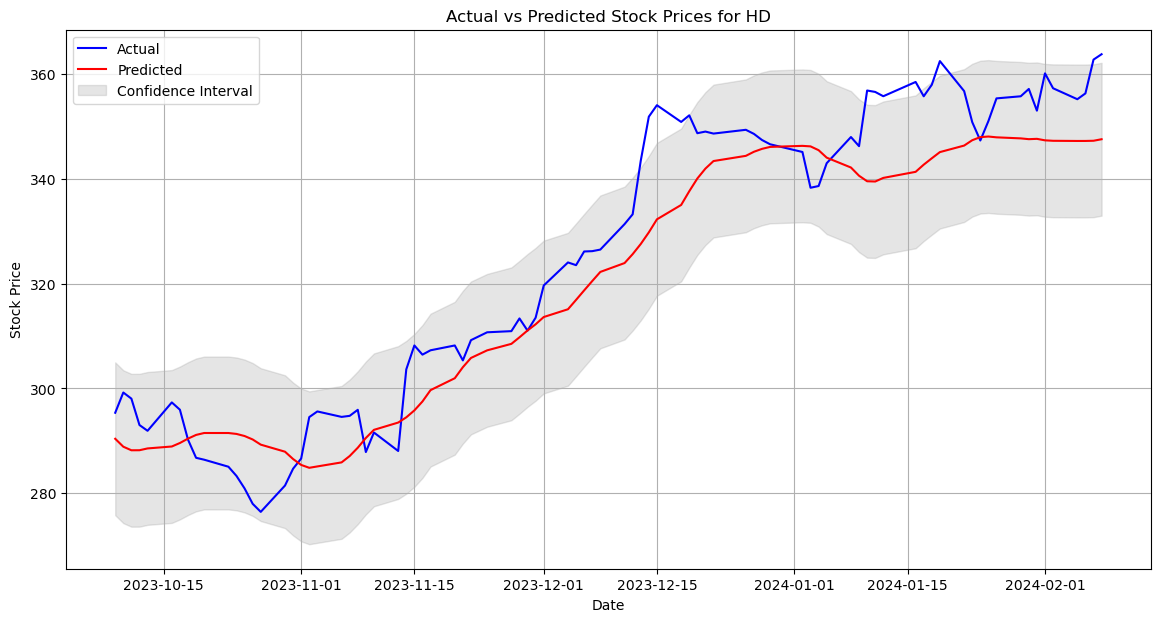

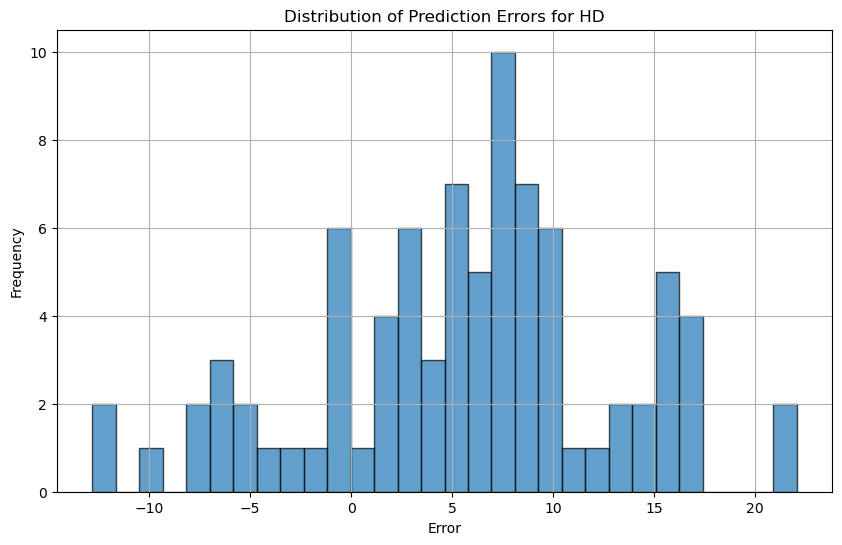

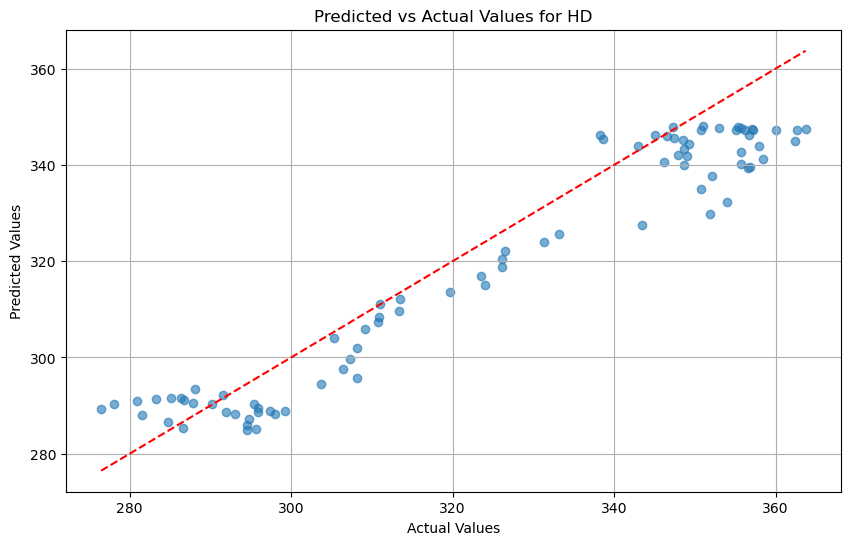

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  155.424104  150.716793  160.131416  158.539993
418 2023-10-10  155.540603  150.833292  160.247914  158.360001
419 2023-10-11  155.702139  150.994828  160.409450  156.179993
420 2023-10-12  155.792580  151.085268  160.499891  156.330002
421 2023-10-13  155.850764  151.143452  160.558075  156.850006
..         ...         ...         ...         ...         ...
497 2024-02-02  158.766992  154.059681  163.474303  156.610001
498 2024-02-05  158.372461  153.665149  163.079772  155.800003
499 2024-02-06  157.968979  153.261668  162.676290  158.059998
500 2024-02-07  157.798138  153.090826  162.505449  157.979996
501 2024-02-08  157.696536  152.989225  162.403847  156.399994

[85 rows x 5 columns]

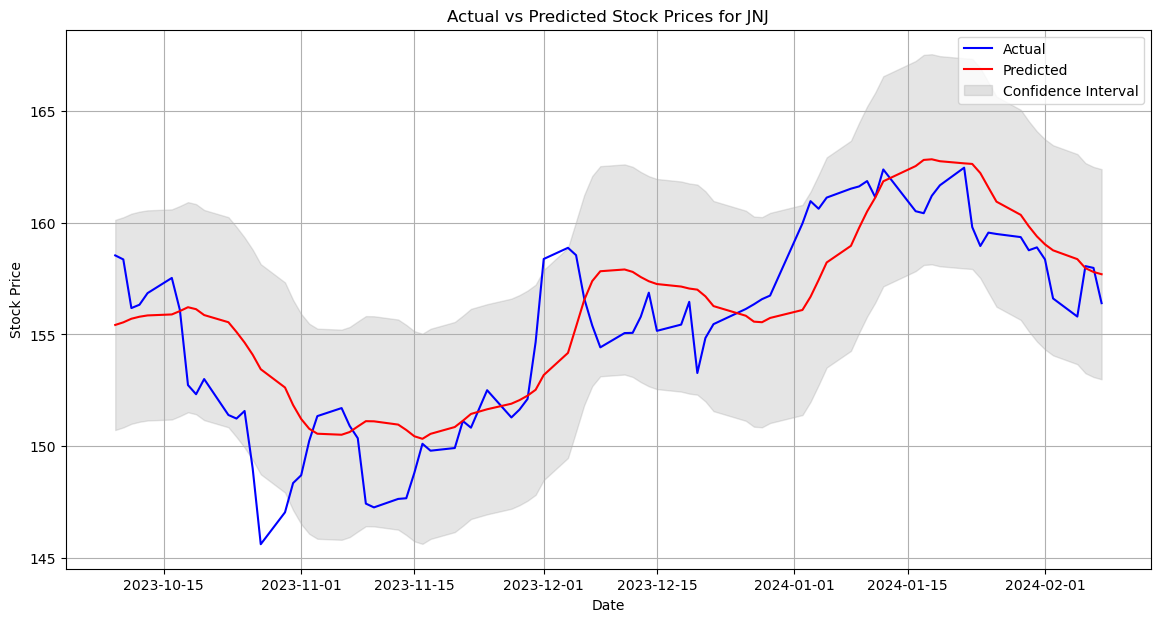

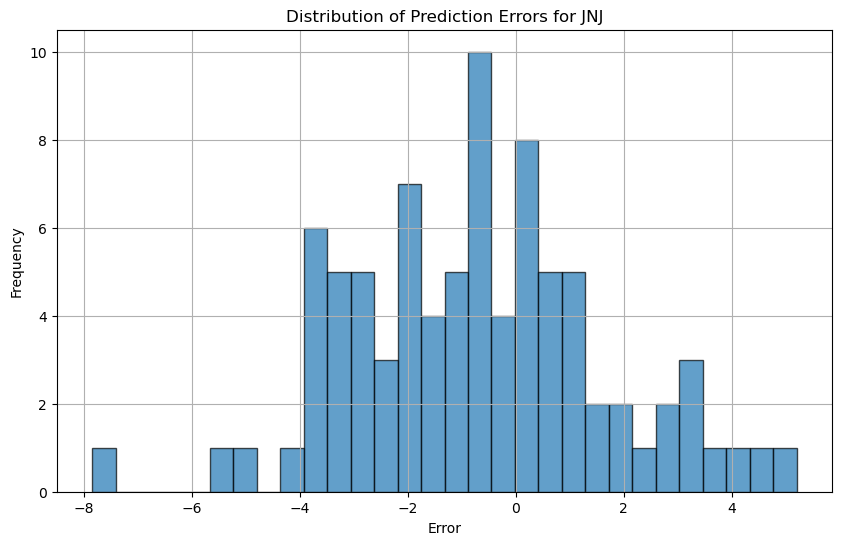

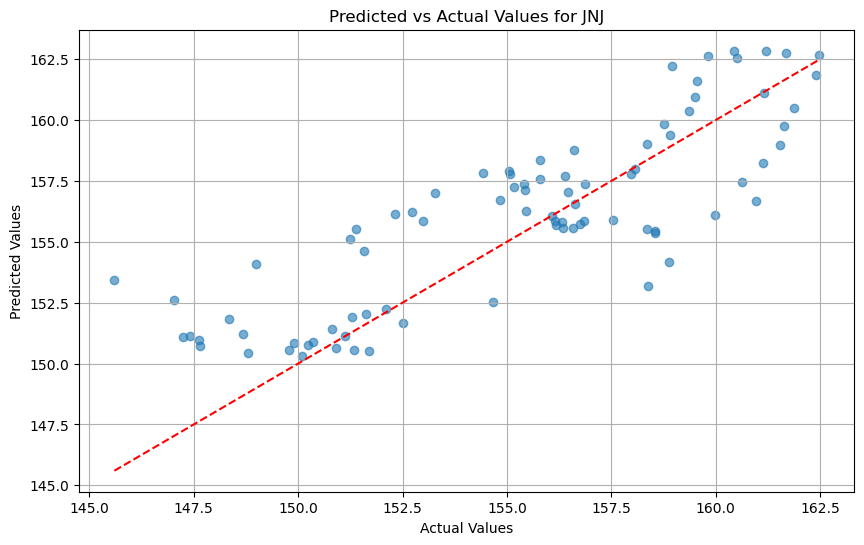

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  143.781935  137.506194  150.057676  144.770004
418 2023-10-10  143.326700  137.050958  149.602441  145.649994
419 2023-10-11  143.248311  136.972570  149.524053  146.149994
420 2023-10-12  143.499975  137.224234  149.775717  145.809998
421 2023-10-13  143.975302  137.699560  150.251043  148.000000
..         ...         ...         ...         ...         ...
497 2024-02-02  170.190619  163.914877  176.466360  174.729996
498 2024-02-05  171.016071  164.740329  177.291812  174.500000
499 2024-02-06  171.810930  165.535189  178.086671  175.100006
500 2024-02-07  172.651601  166.375859  178.927342  175.429993
501 2024-02-08  173.386971  167.111230  179.662712  174.800003

[85 rows x 5 columns]

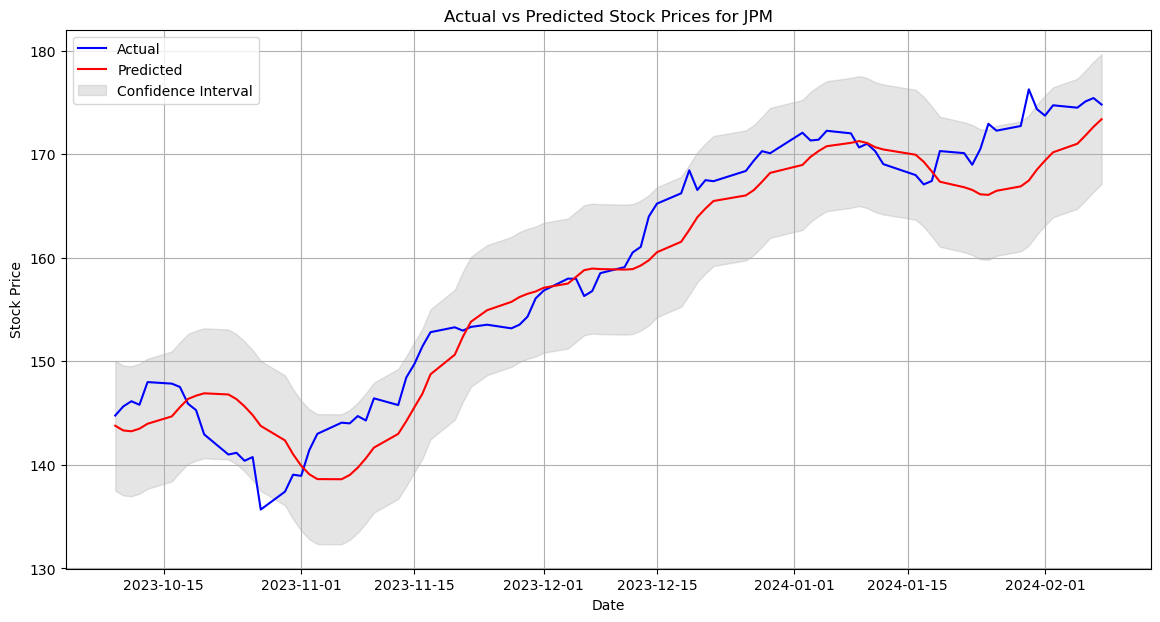

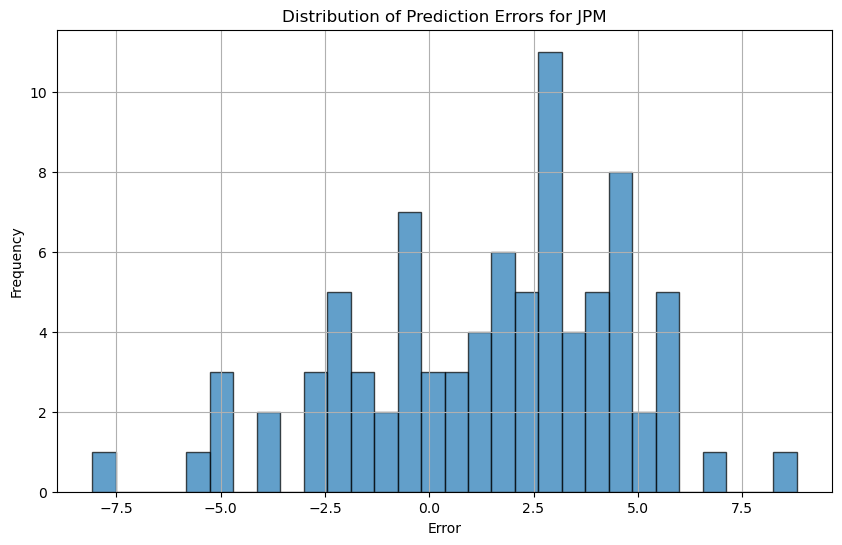

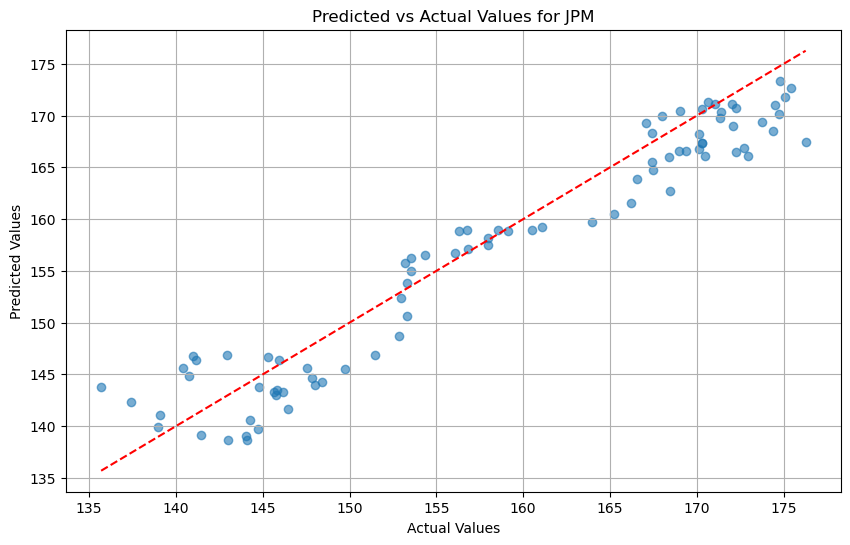

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  556.622169  504.669436  608.574901  571.760010
418 2023-10-10  555.644297  503.691564  607.597029  579.309998
419 2023-10-11  556.224881  504.272149  608.177613  605.280029
420 2023-10-12  558.707204  506.754472  610.659936  610.500000
421 2023-10-13  562.557134  510.604401  614.509866  609.200012
..         ...         ...         ...         ...         ...
497 2024-02-02  637.067958  585.115226  689.020691  667.650024
498 2024-02-05  638.462285  586.509553  690.415017  706.200012
499 2024-02-06  640.893591  588.940859  692.846323  705.030029
500 2024-02-07  644.081703  592.128970  696.034435  725.380005
501 2024-02-08  648.327285  596.374553  700.280018  735.679993

[85 rows x 5 columns]

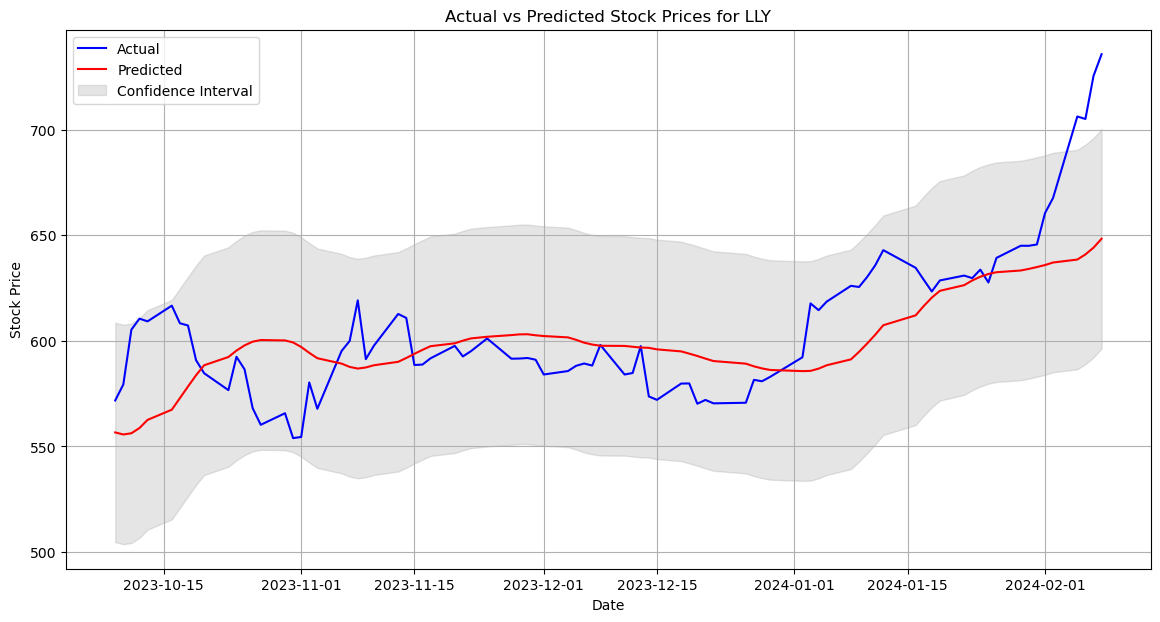

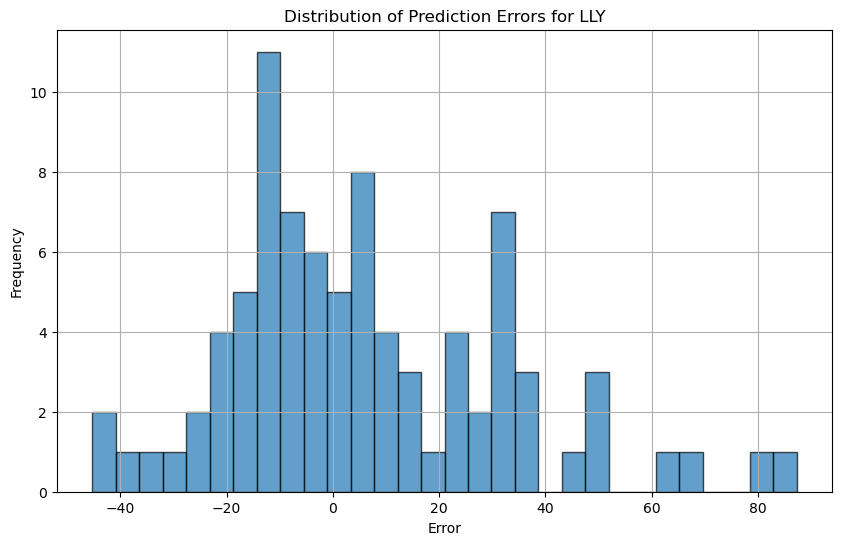

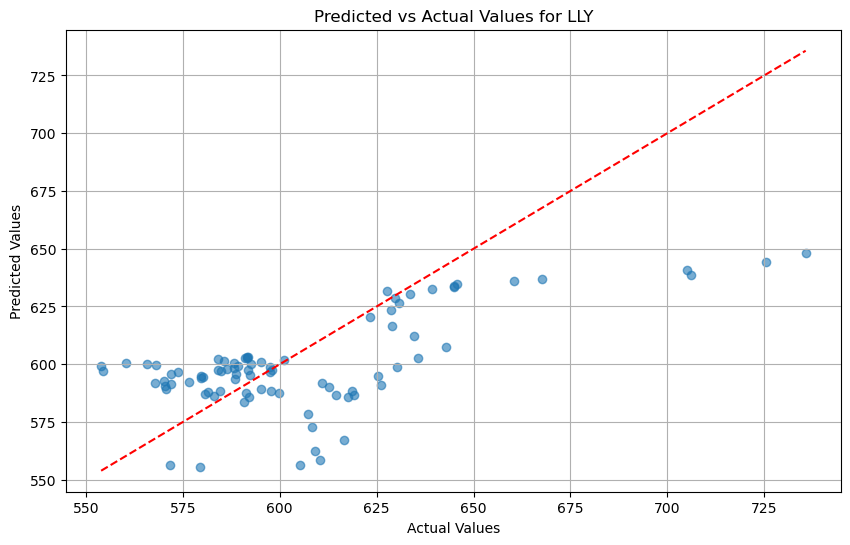

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  393.362965  377.480298  409.245631  394.739990
418 2023-10-10  393.541216  377.658549  409.423882  400.369995
419 2023-10-11  394.591238  378.708571  410.473904  399.809998
420 2023-10-12  396.402799  380.520132  412.285465  399.899994
421 2023-10-13  398.334435  382.451768  414.217101  398.029999
..         ...         ...         ...         ...         ...
497 2024-02-02  452.367088  436.484421  468.249754  460.579987
498 2024-02-05  454.686150  438.803483  470.568816  456.760010
499 2024-02-06  456.097994  440.215328  471.980661  460.500000
500 2024-02-07  457.191028  441.308362  473.073695  461.910004
501 2024-02-08  458.111068  442.228401  473.993734  458.260010

[85 rows x 5 columns]

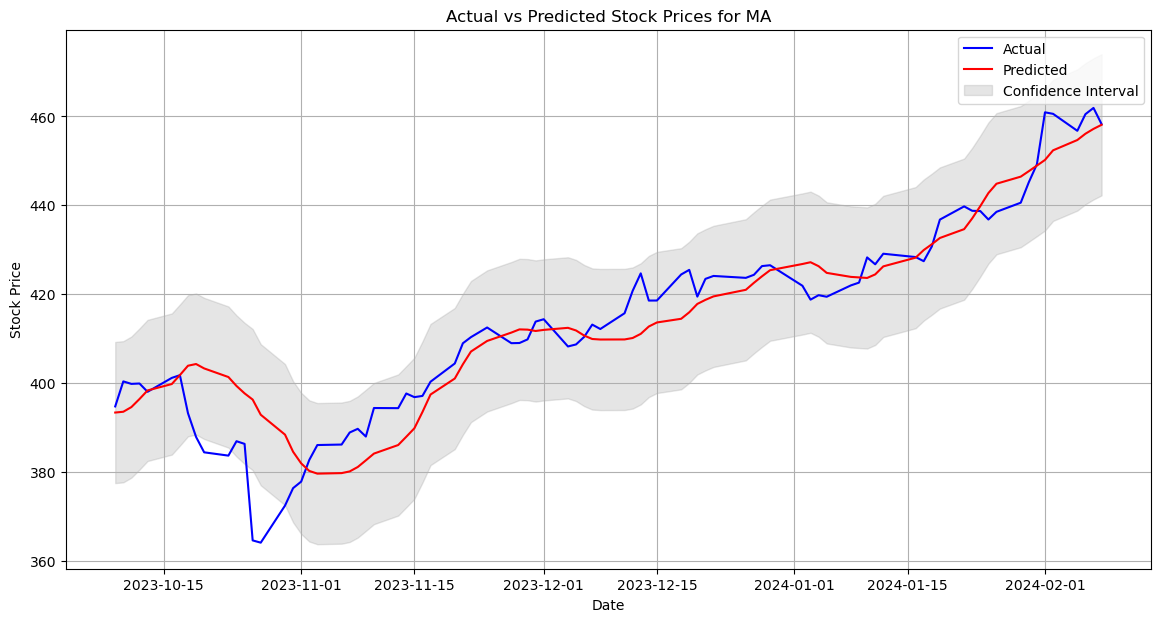

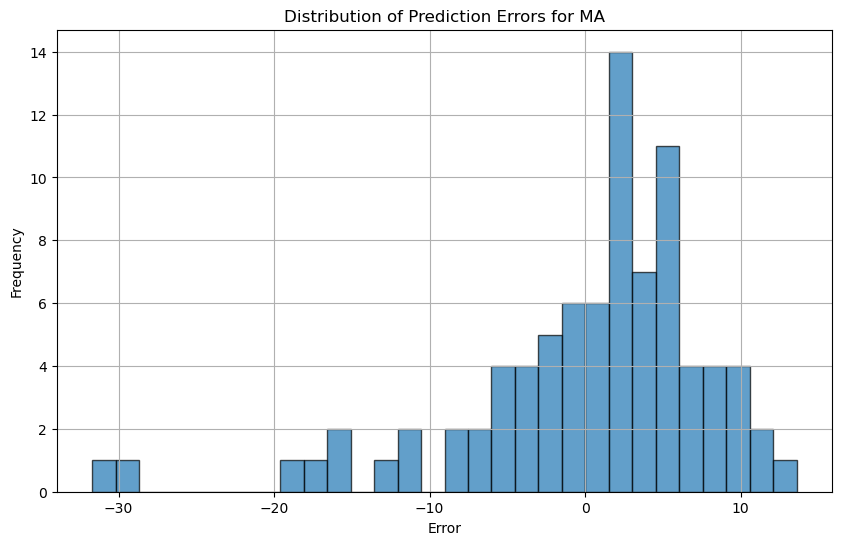

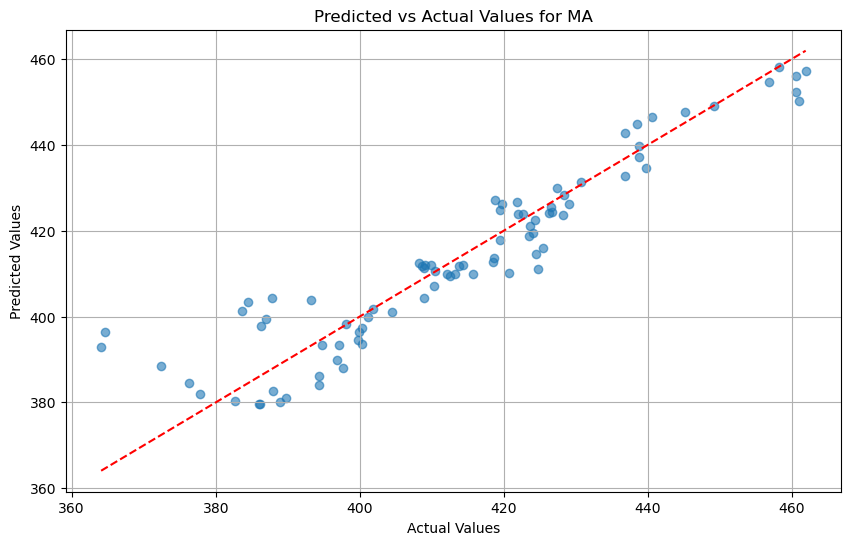

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  311.091515  270.777036  351.405995  318.359985
418 2023-10-10  311.991613  271.677133  352.306093  321.839996
419 2023-10-11  313.554875  273.240395  353.869355  327.820007
420 2023-10-12  315.776561  275.462081  356.091041  324.160004
421 2023-10-13  318.147159  277.832679  358.461639  314.690002
..         ...         ...         ...         ...         ...
497 2024-02-02  393.107822  352.793342  433.422302  474.989990
498 2024-02-05  395.530910  355.216430  435.845390  459.410004
499 2024-02-06  398.572934  358.258454  438.887413  454.720001
500 2024-02-07  402.483919  362.169440  442.798399  469.589996
501 2024-02-08  406.722506  366.408026  447.036986  470.000000

[85 rows x 5 columns]

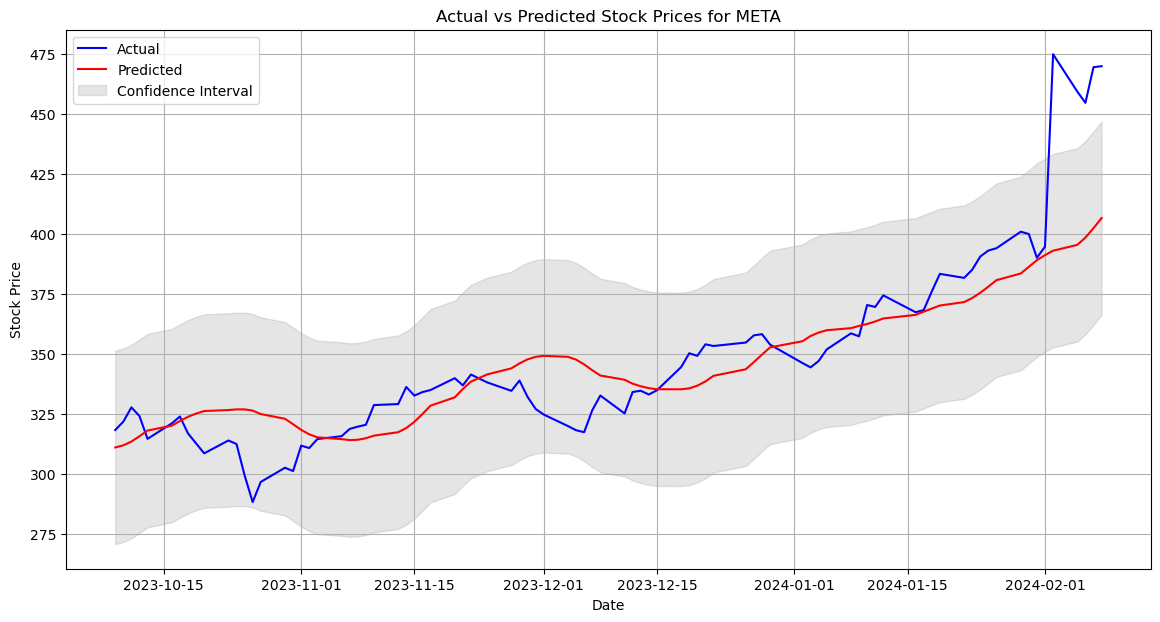

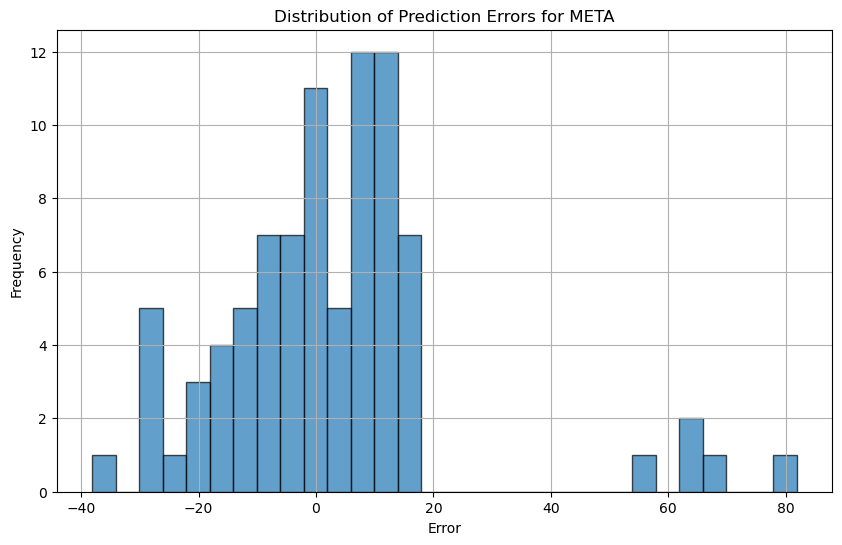

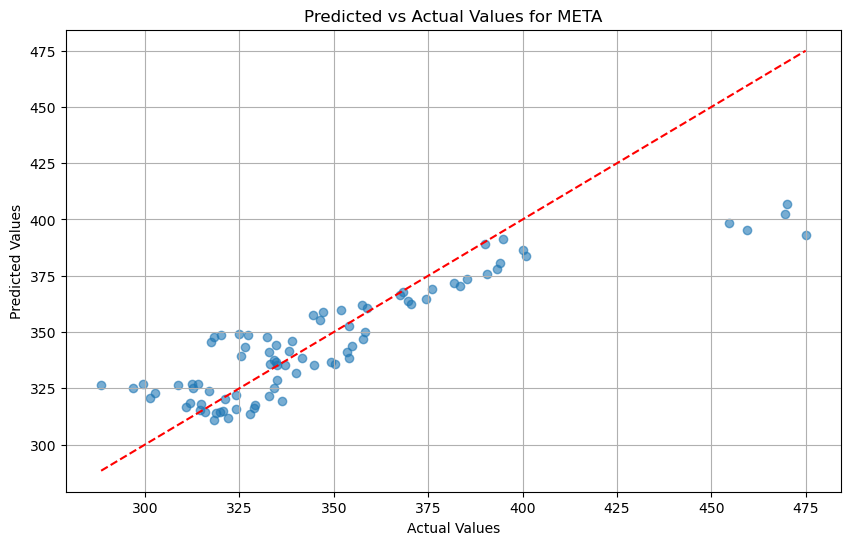

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  103.273153   98.909410  107.636897  104.500000
418 2023-10-10  103.670852   99.307109  108.034595  103.610001
419 2023-10-11  104.005124   99.641381  108.368868  103.459999
420 2023-10-12  104.267957   99.904213  108.631700  103.589996
421 2023-10-13  104.475827  100.112084  108.839570  104.010002
..         ...         ...         ...         ...         ...
497 2024-02-02  121.503188  117.139444  125.866931  126.410004
498 2024-02-05  122.309043  117.945299  126.672786  126.180000
499 2024-02-06  123.177577  118.813834  127.541320  126.879997
500 2024-02-07  124.071577  119.707834  128.435320  127.470001
501 2024-02-08  124.888393  120.524650  129.252137  126.610001

[85 rows x 5 columns]

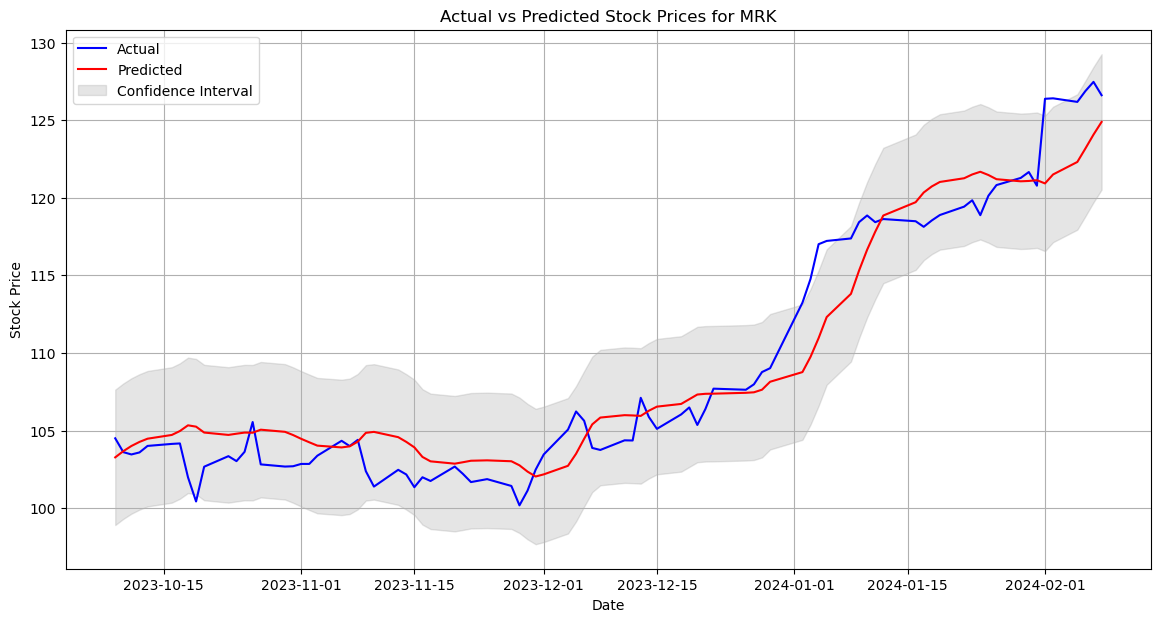

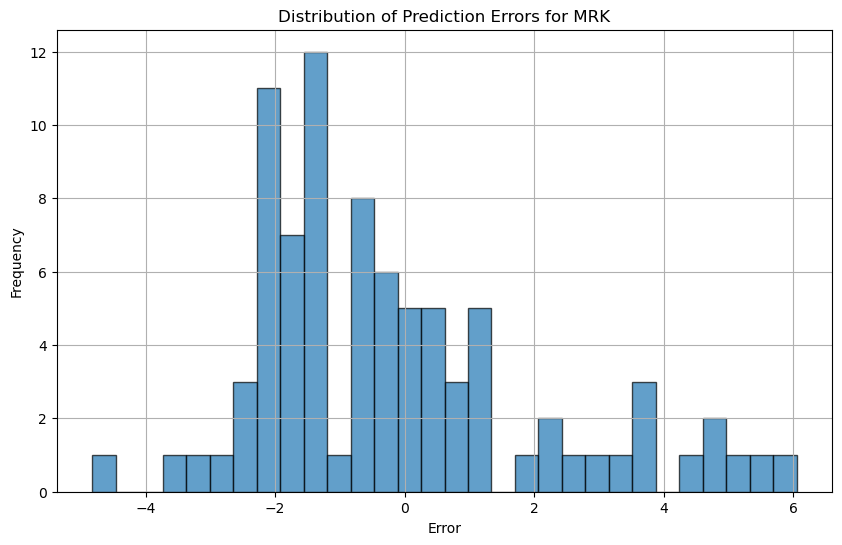

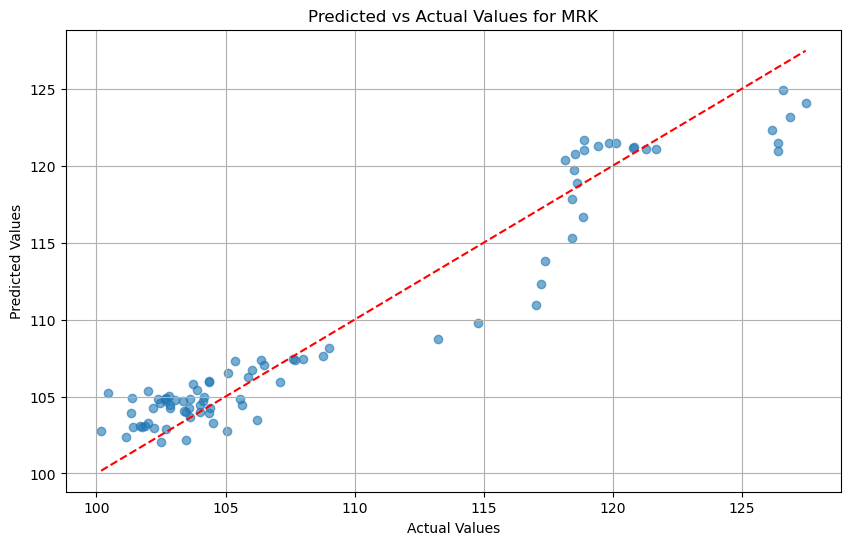

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  319.096232  305.355895  332.836570  329.820007
418 2023-10-10  319.827272  306.086935  333.567609  328.390015
419 2023-10-11  321.305183  307.564845  335.045520  332.420013
420 2023-10-12  323.418332  309.677995  337.158669  331.160004
421 2023-10-13  325.763908  312.023571  339.504245  327.730011
..         ...         ...         ...         ...         ...
497 2024-02-02  402.847031  389.106694  416.587368  411.220001
498 2024-02-05  402.807791  389.067453  416.548128  405.649994
499 2024-02-06  402.294906  388.554569  416.035244  405.489990
500 2024-02-07  401.799545  388.059208  415.539883  414.049988
501 2024-02-08  401.419474  387.679137  415.159812  414.109985

[85 rows x 5 columns]

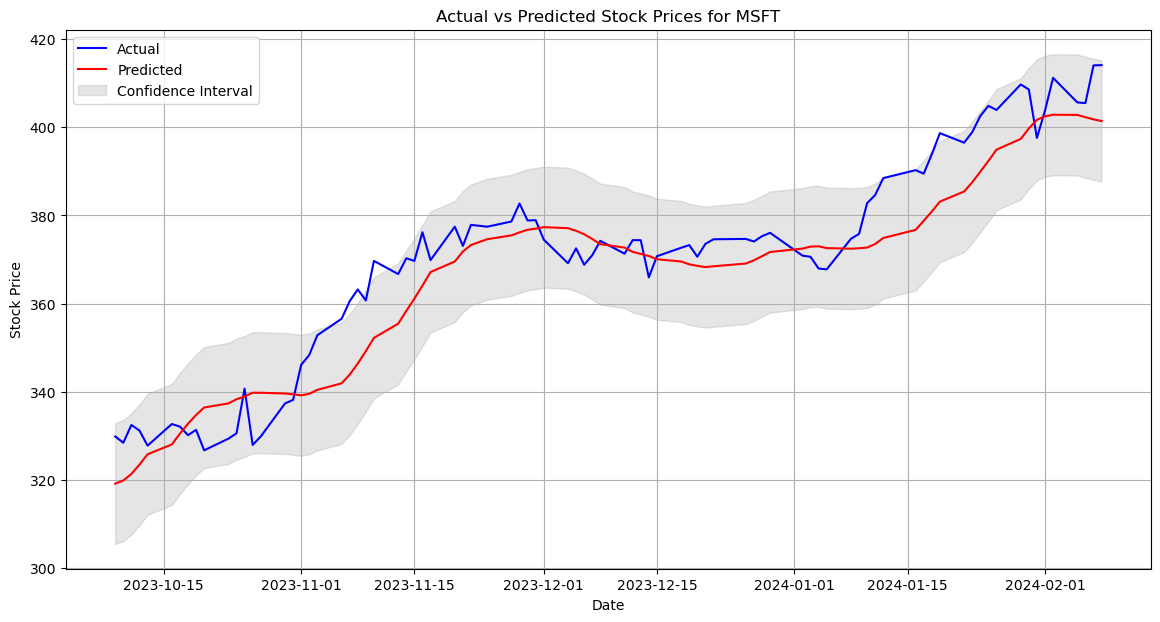

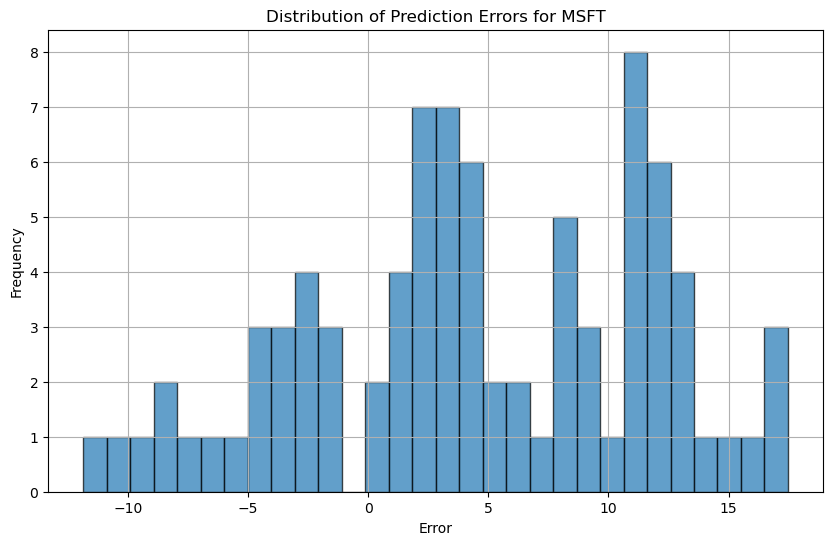

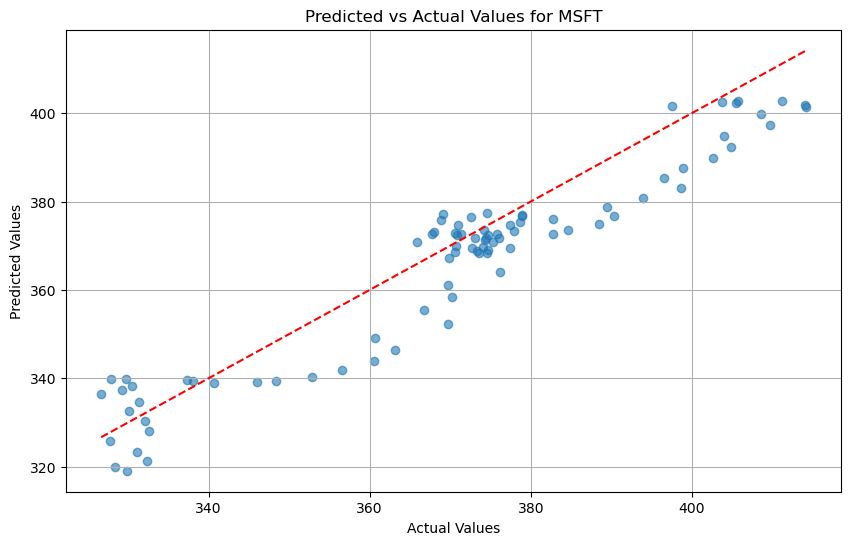

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  452.882324  382.914195  522.850454  452.730011
418 2023-10-10  456.667040  386.698910  526.635169  457.980011
419 2023-10-11  461.094612  391.126482  531.062742  468.059998
420 2023-10-12  466.619602  396.651473  536.587732  469.450012
421 2023-10-13  472.125364  402.157234  542.093493  454.609985
..         ...         ...         ...         ...         ...
497 2024-02-02  595.826134  525.858004  665.794264  661.599976
498 2024-02-05  599.081896  529.113766  669.050026  693.320007
499 2024-02-06  603.283977  533.315847  673.252106  682.229980
500 2024-02-07  607.858613  537.890483  677.826743  700.989990
501 2024-02-08  612.863914  542.895784  682.832044  696.409973

[85 rows x 5 columns]

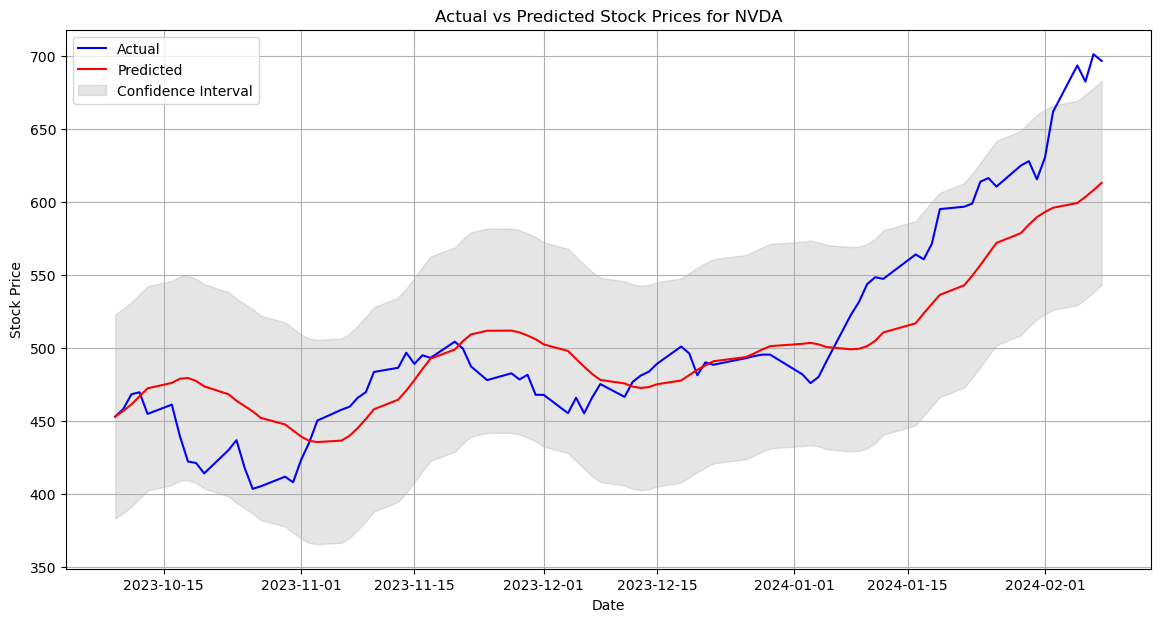

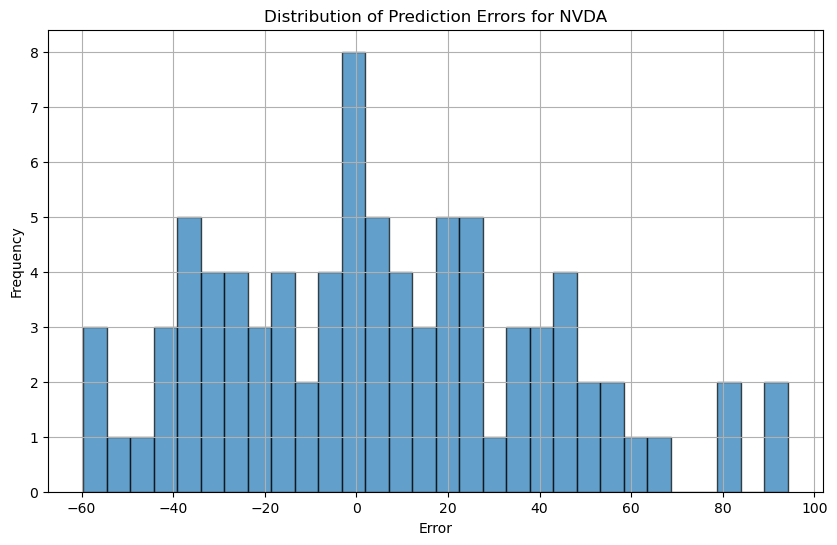

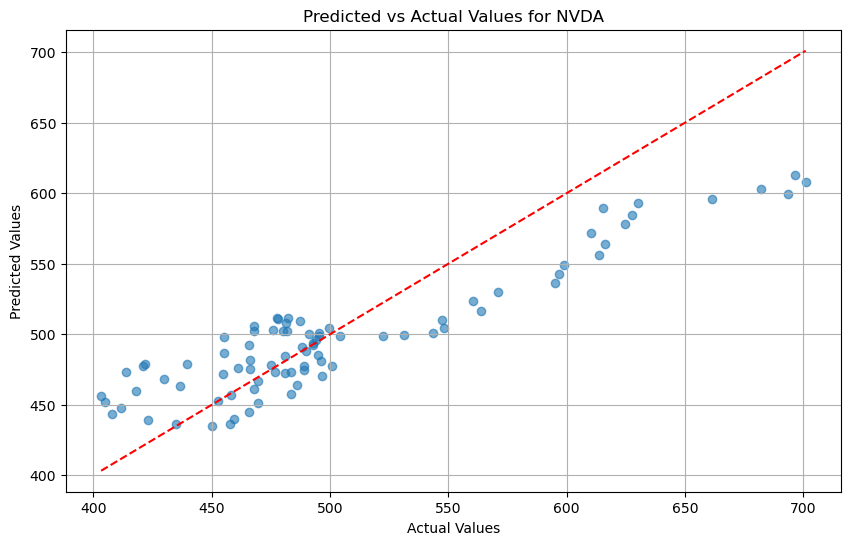

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  145.399617  140.507909  150.291326  143.360001
418 2023-10-10  144.609598  139.717889  149.501306  144.779999
419 2023-10-11  144.019615  139.127907  148.911324  143.000000
420 2023-10-12  143.509843  138.618135  148.401552  143.320007
421 2023-10-13  143.118240  138.226531  148.009948  144.690002
..         ...         ...         ...         ...         ...
497 2024-02-02  154.803874  149.912165  159.695582  158.089996
498 2024-02-05  155.492671  150.600962  160.384379  158.210007
499 2024-02-06  156.160535  151.268826  161.052243  158.960007
500 2024-02-07  156.751354  151.859645  161.643062  159.119995
501 2024-02-08  157.355086  152.463378  162.246795  158.639999

[85 rows x 5 columns]

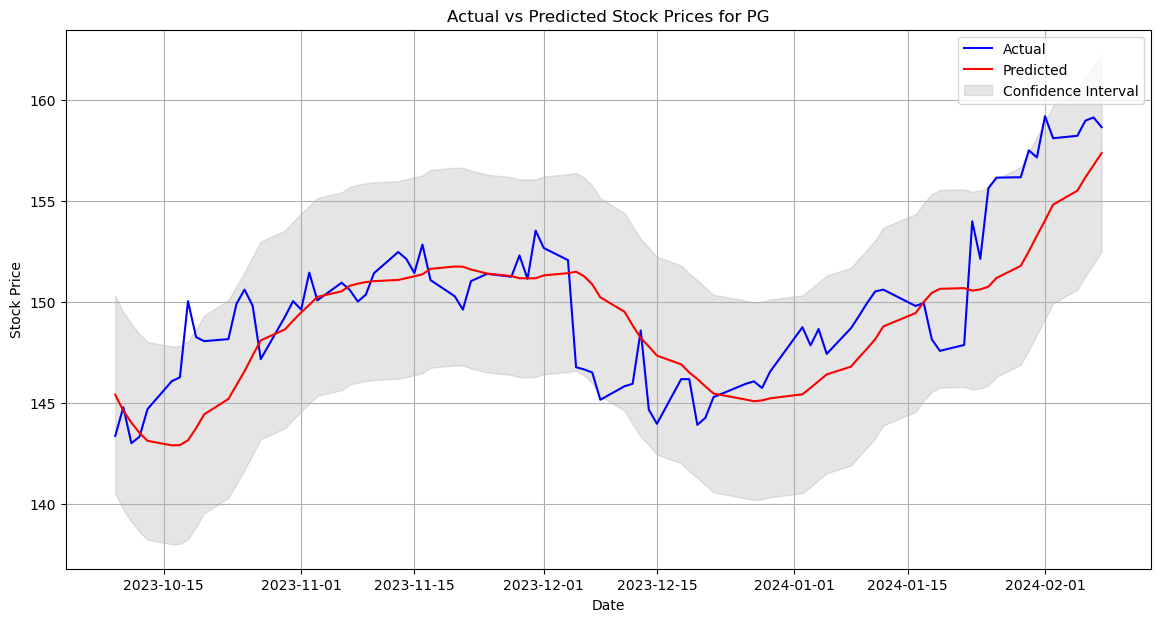

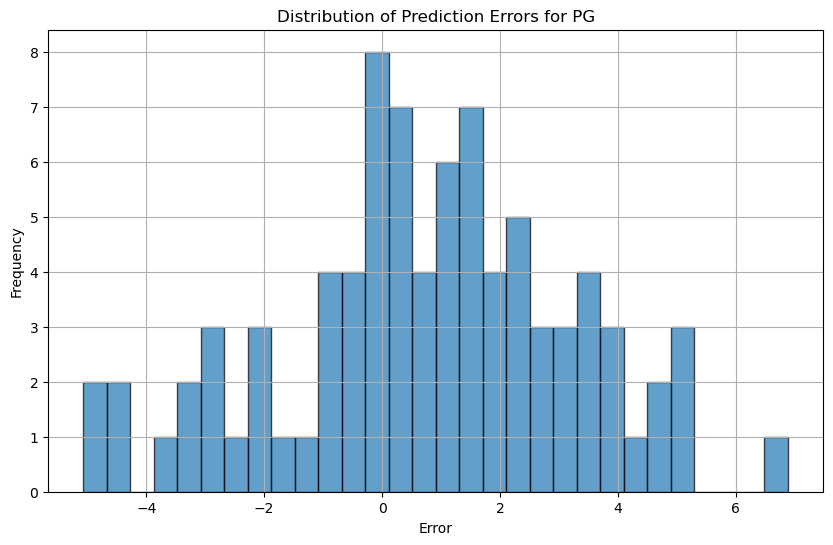

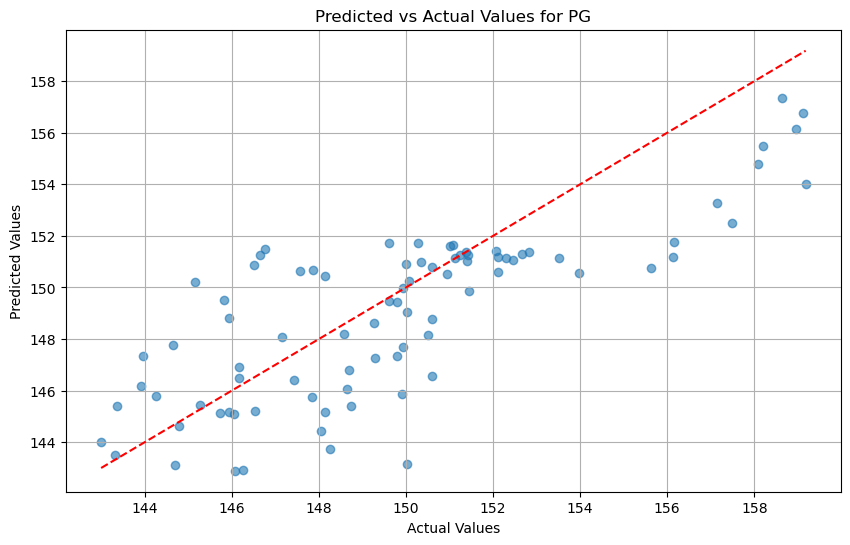

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  250.273501  230.242526  270.304476  259.670013
418 2023-10-10  253.635277  233.604302  273.666252  263.619995
419 2023-10-11  257.091532  237.060556  277.122507  262.989990
420 2023-10-12  260.507016  240.476040  280.537991  258.869995
421 2023-10-13  263.619175  243.588200  283.650150  251.119995
..         ...         ...         ...         ...         ...
497 2024-02-02  184.599204  164.568229  204.630180  187.910004
498 2024-02-05  183.579669  163.548694  203.610644  181.059998
499 2024-02-06  181.640494  161.609518  201.671469  185.100006
500 2024-02-07  180.217958  160.186983  200.248934  187.580002
501 2024-02-08  179.694849  159.663874  199.725824  189.559998

[85 rows x 5 columns]

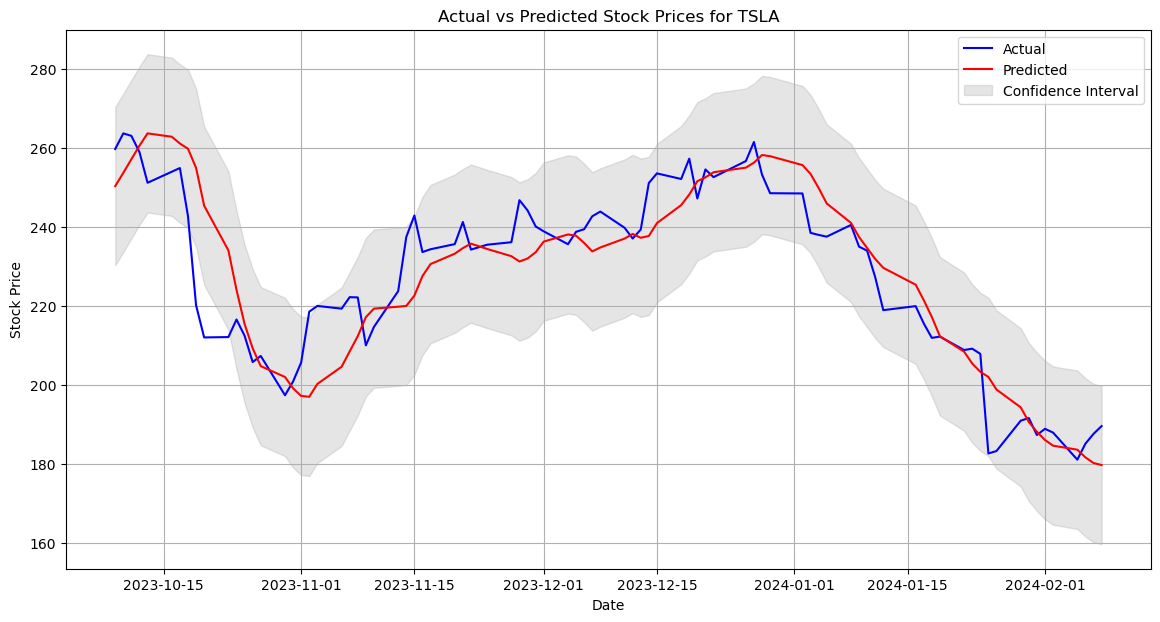

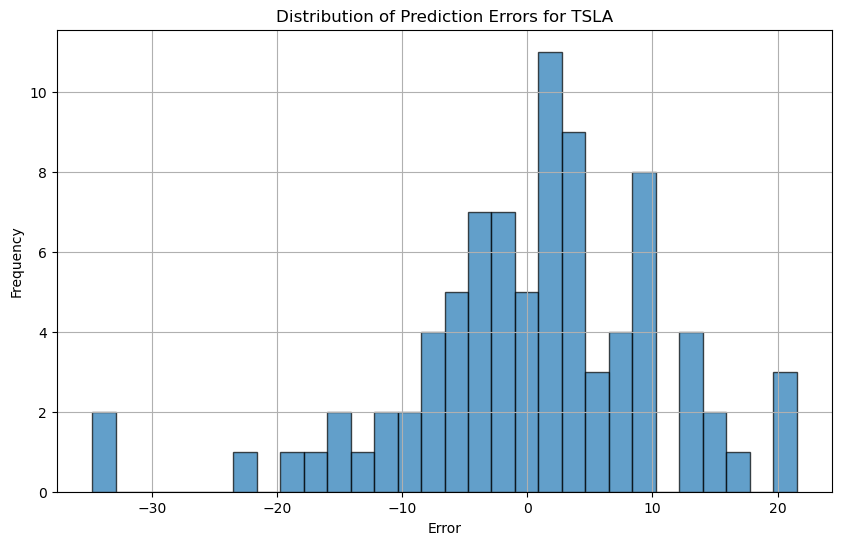

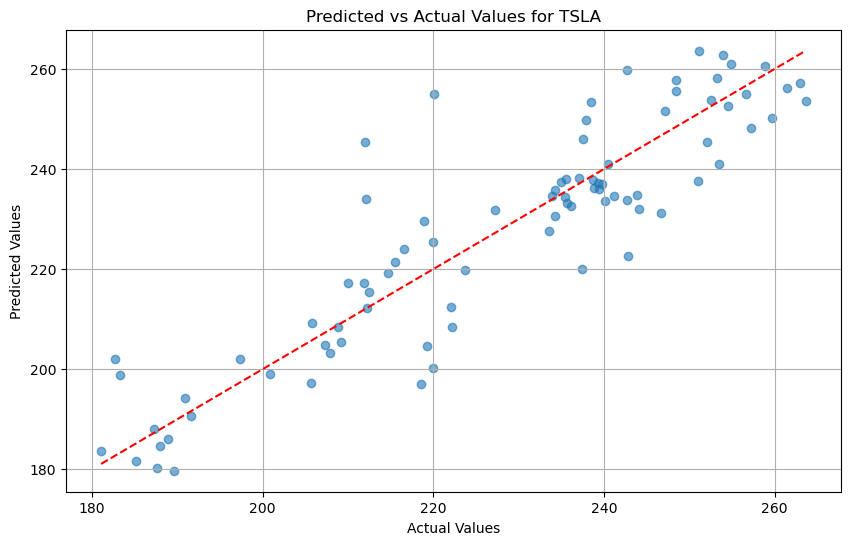

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  514.141040  500.525646  527.756434  526.510010
418 2023-10-10  519.861418  506.246024  533.476812  524.239990
419 2023-10-11  522.589838  508.974444  536.205232  524.130005
420 2023-10-12  522.736107  509.120713  536.351501  525.539978
421 2023-10-13  522.363479  508.748086  535.978873  539.400024
..         ...         ...         ...         ...         ...
497 2024-02-02  510.634673  497.019279  524.250067  510.230011
498 2024-02-05  511.854922  498.239528  525.470316  502.959991
499 2024-02-06  510.856525  497.241131  524.471919  510.670013
500 2024-02-07  510.134291  496.518897  523.749685  519.390015
501 2024-02-08  512.887427  499.272033  526.502821  520.090027

[85 rows x 5 columns]

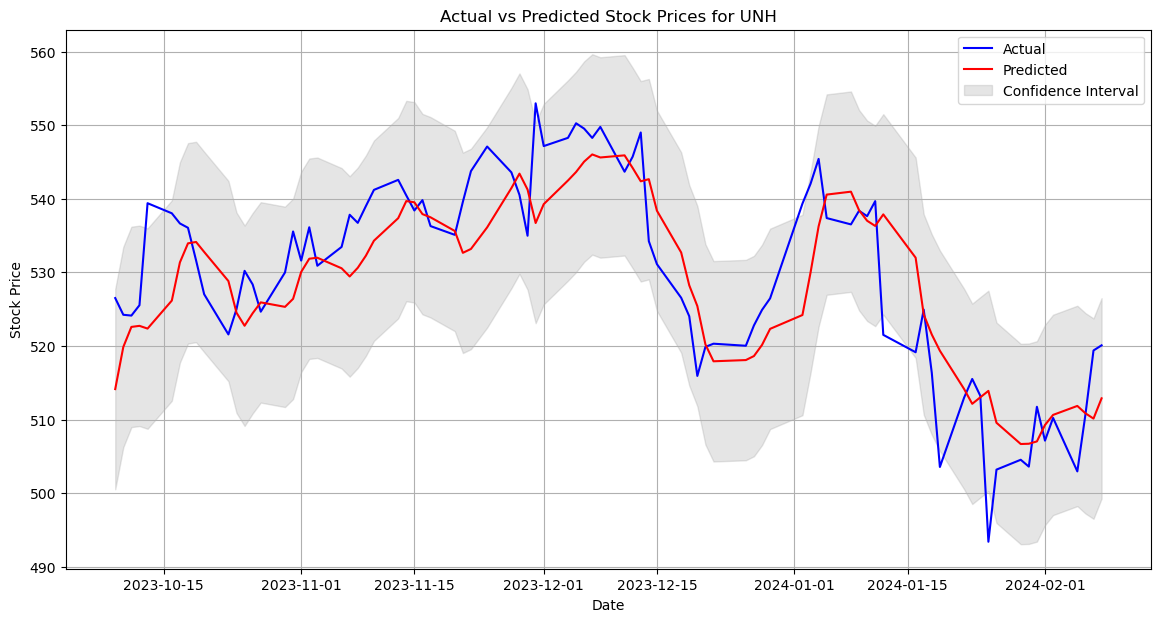

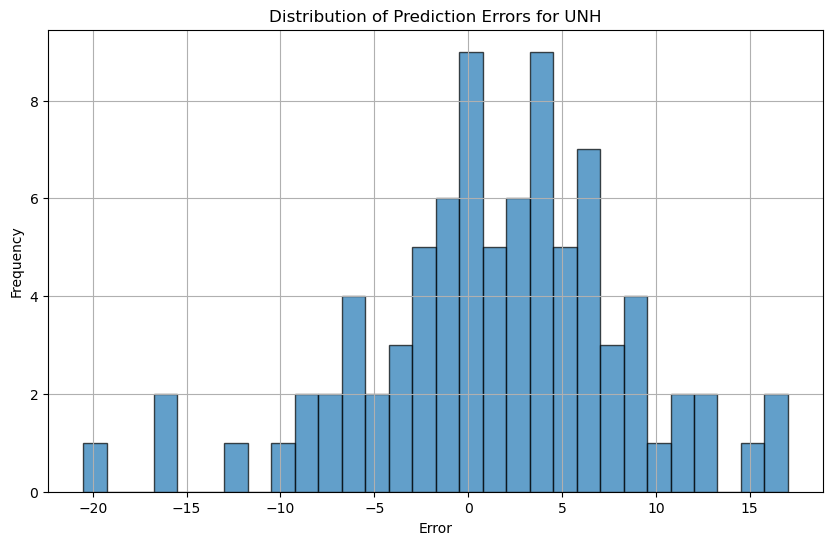

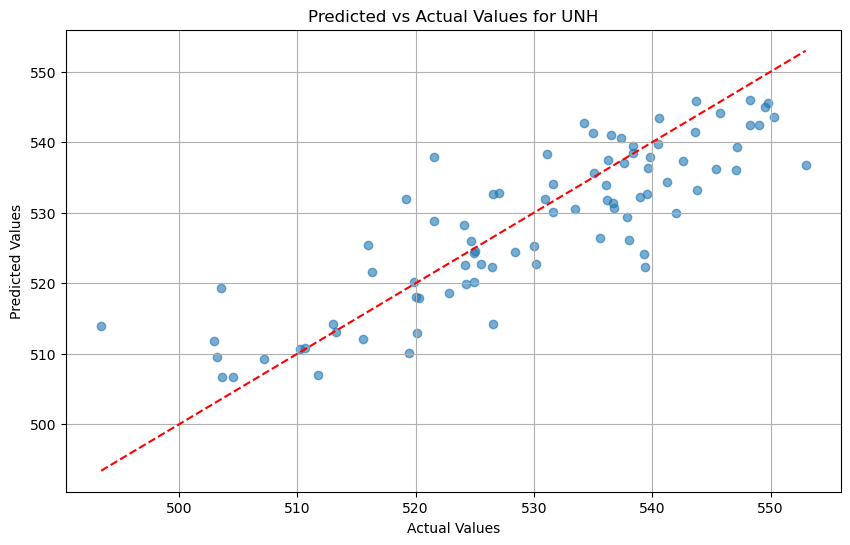

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  231.106952  224.279459  237.934445  234.440002
418 2023-10-10  231.081889  224.254396  237.909382  236.600006
419 2023-10-11  231.374231  224.546738  238.201724  235.679993
420 2023-10-12  232.033098  225.205605  238.860591  236.779999
421 2023-10-13  232.980007  226.152514  239.807500  237.669998
..         ...         ...         ...         ...         ...
497 2024-02-02  274.858903  268.031410  281.686397  277.179993
498 2024-02-05  274.909655  268.082161  281.737148  275.579987
499 2024-02-06  274.879346  268.051853  281.706839  276.760010
500 2024-02-07  274.851996  268.024503  281.679489  279.390015
501 2024-02-08  274.947841  268.120348  281.775334  275.779999

[85 rows x 5 columns]

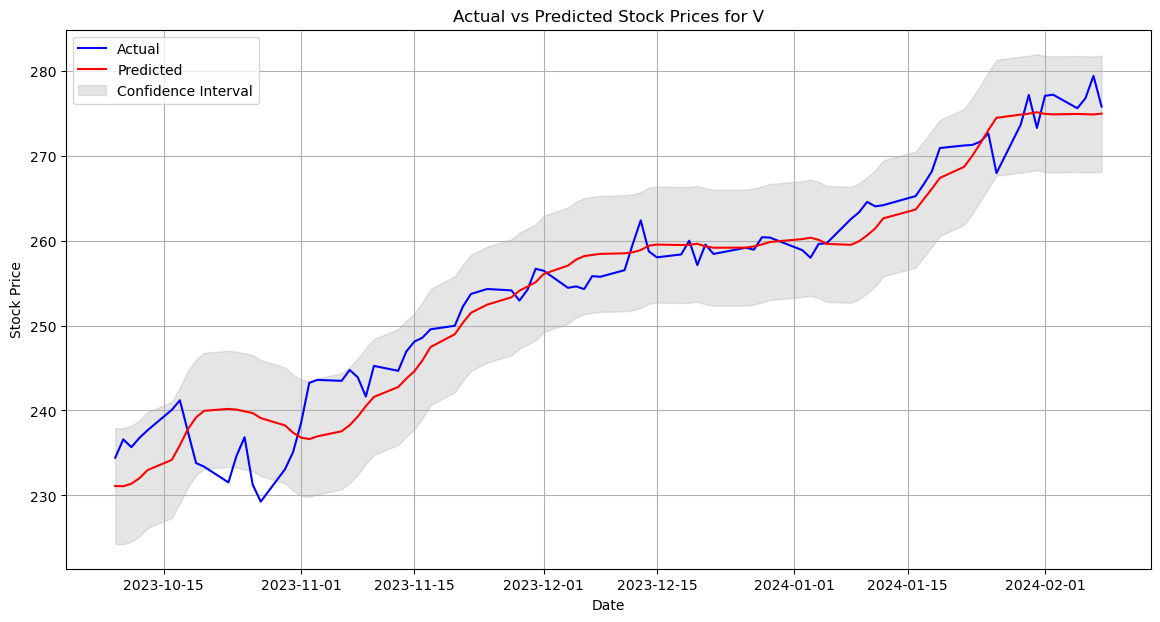

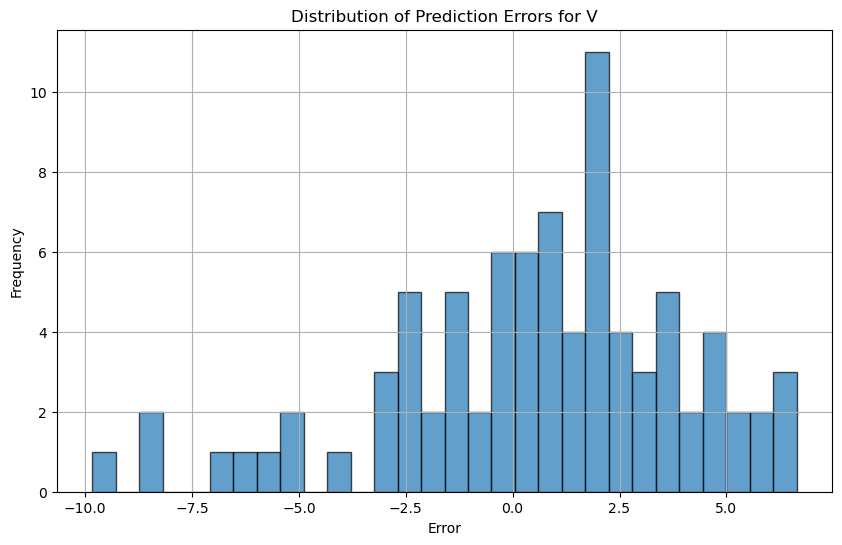

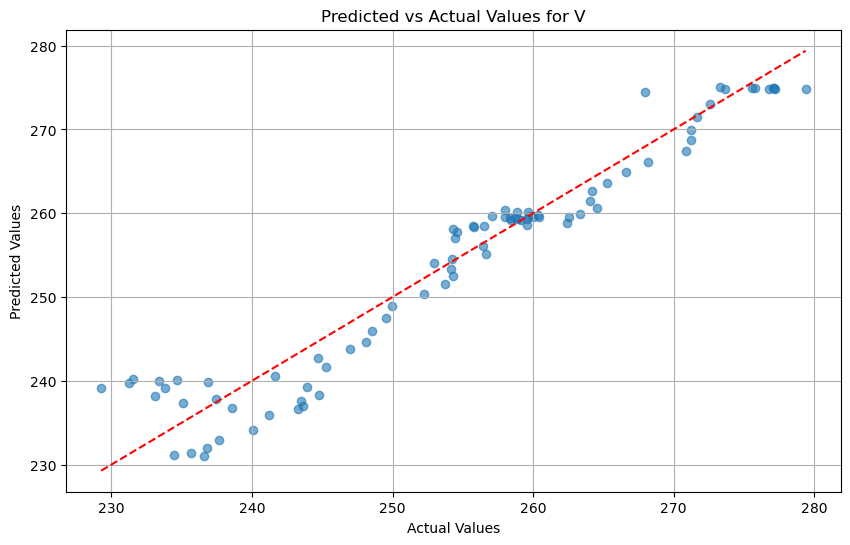

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


ds        yhat  yhat_lower  yhat_upper           y
417 2023-10-09  112.537680  107.785966  117.289394  110.919998
418 2023-10-10  111.910344  107.158630  116.662058  110.449997
419 2023-10-11  111.277938  106.526223  116.029652  106.489998
420 2023-10-12  110.666945  105.915231  115.418660  106.470001
421 2023-10-13  110.083322  105.331608  114.835037  109.870003
..         ...         ...         ...         ...         ...
497 2024-02-02  100.523933   95.772219  105.275647  101.970001
498 2024-02-05  101.031091   96.279377  105.782805  101.550003
499 2024-02-06  101.472864   96.721150  106.224578  102.250000
500 2024-02-07  101.865317   97.113602  106.617031  102.220001
501 2024-02-08  102.209411   97.457697  106.961126  103.970001

[85 rows x 5 columns]

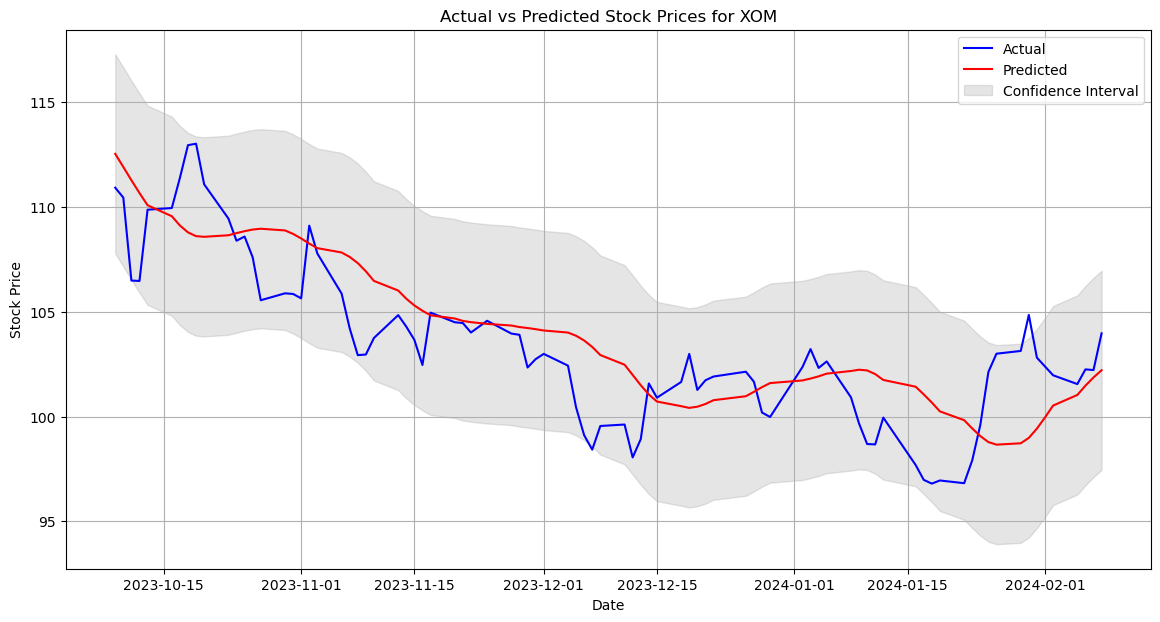

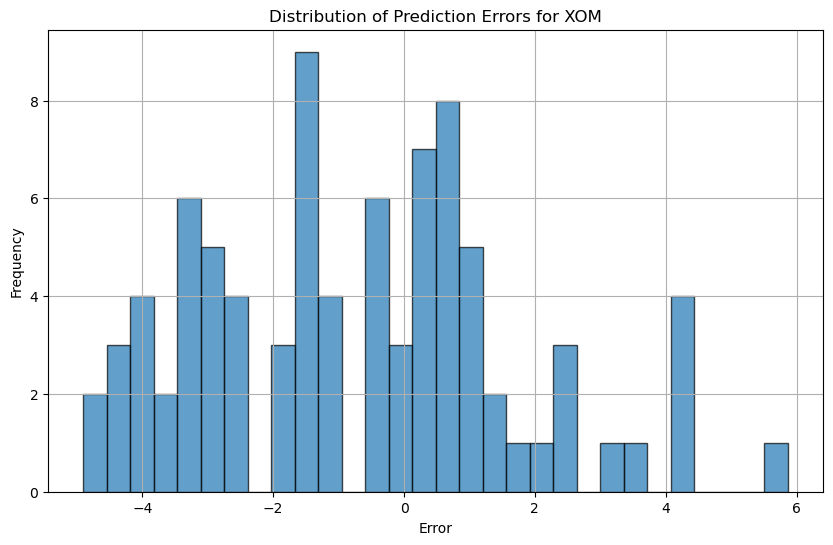

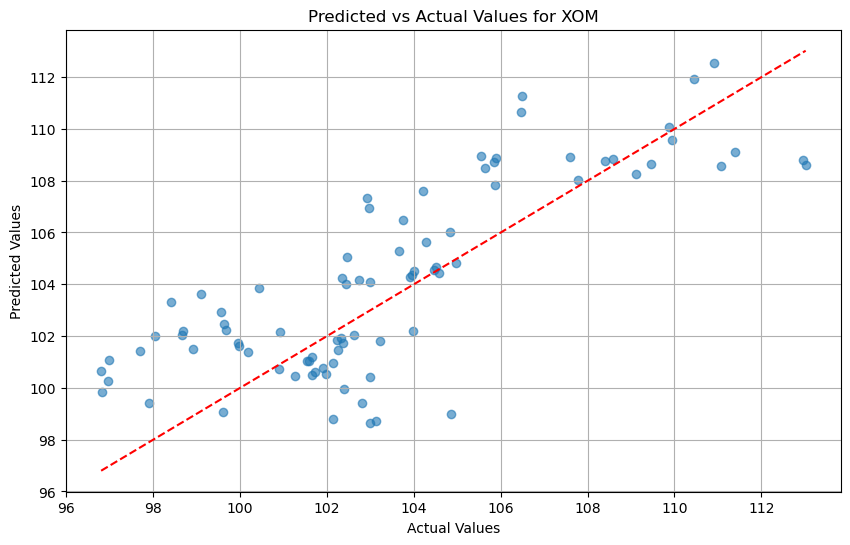

In [27]:
# Plot forecast vs actual with confidence interval
for stock, (X, y) in prepared_data_lstm.items():
    train_size = int(len(X) * 0.8)
    test = stock_data[stock].iloc[train_size+60:]  # Adjust to match the look-back period
    
    # Predict
    X_test = X[train_size:]
    predictions = models_lstm[stock].predict(X_test)
    predictions = scalers[stock].inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], 6)))))[:, 0]
    
    residuals = test['close'].values - predictions
    std_residuals = np.std(residuals)
    
    # Assuming the residuals follow a normal distribution, calculate the prediction interval
    ci_upper = predictions + 1.96 * std_residuals
    ci_lower = predictions - 1.96 * std_residuals
    
    # Create a DataFrame for combined results
    combined_df = pd.DataFrame({
        'ds': test['date'],
        'yhat': predictions,
        'yhat_lower': ci_lower,
        'yhat_upper': ci_upper,
        'y': test['close'].values
    })
    
    display(combined_df)
    
    plt.figure(figsize=(14, 7))
    plt.plot(test['date'], test['close'], label='Actual', color='blue')
    plt.plot(test['date'], predictions, label='Predicted', color='red')
    plt.fill_between(test['date'], ci_lower, ci_upper, color='gray', alpha=0.2, label='Confidence Interval')
    plt.title(f'Actual vs Predicted Stock Prices for {stock}')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of Prediction Errors for {stock}')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    # Scatter plot of predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(test['close'].values, predictions, alpha=0.6)
    plt.plot([min(test['close'].values), max(test['close'].values)], [min(test['close'].values), max(test['close'].values)], color='red', linestyle='--')
    plt.title(f'Predicted vs Actual Values for {stock}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()